# DUSP1 Analysis and Visualization Notebook

This notebook demonstrates how to use the new analysis manager code from `Analysis_DUSP1.py`.

In this notebook, we will:
1. Load the processed CSV files (spots, clusters, and cell properties).
2. Instantiate the measurement manager (DUSP1Measurement) and compute cell-level metrics,
   with optional SNR filtering.
3. Create a DisplayManager instance to visualize gating overlays and cell crops.
4. (Optional) Use the new expression grouping and visualization functions.

Make sure that `Analysis_DUSP1.py` is in the same directory or on the Python path.

In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import dask.array as da
import os
import sys
import logging
import seaborn as sns
import datetime

# Today's date
today = datetime.date.today()
# Format date as 'Mar21' (for example)
date_str = today.strftime("%b%d")

logging.getLogger('matplotlib.font_manager').disabled = True
numba_logger = logging.getLogger('numba')
numba_logger.setLevel(logging.WARNING)

matplotlib_logger = logging.getLogger('matplotlib')
matplotlib_logger.setLevel(logging.WARNING)

src_path = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
print(src_path)
sys.path.append(src_path)

from src.Analysis_DUSP1_v2 import DUSP1AnalysisManager, SNRAnalysis, DUSP1Measurement, DUSP1DisplayManager, DUSP1_filtering

# Use the log file to search for analyses

In [ ]:
loc = None
log_location = r'/Volumes/share/Users/Eric/GR_DUSP1_reruns'

In [ ]:
# Load in csv files
filtered_cell_level_results = pd.read_csv('/Users/ericron/Desktop/AngelFISH/Publications/Ron_2024/dataframes/TS_R1_cell_level_results_Apr09_filtered.csv')
filtered_spots = pd.read_csv('/Users/ericron/Desktop/AngelFISH/Publications/Ron_2024/dataframes/DUSP1_D_merged_spots_Apr09_filtered.csv')
removed_spots = pd.read_csv('/Users/ericron/Desktop/AngelFISH/Publications/Ron_2024/dataframes/DUSP1_D_merged_spots_Apr09_removed.csv')
filtered_clusters = pd.read_csv('/Users/ericron/Desktop/AngelFISH/Publications/Ron_2024/dataframes/DUSP1_D_merged_clusters_Apr09_filtered.csv')
filtered_cellprops = pd.read_csv('/Users/ericron/Desktop/AngelFISH/Publications/Ron_2024/dataframes/DUSP1_D_merged_cellprops_Apr09_filtered.csv')

In [ ]:
filtered_cell_level_results.keys()

Reference (control) data sample:
      Unnamed: 0  unique_cell_id  touching_border  MG_count  nuc_MG_count  \
1231        1834            1834            False       171            43   
1232        1836            1836            False        69            18   
1233        1837            1837            False       162            47   
1234        1838            1838            False       128            34   
1235        1839            1839            False        53            13   

      cyto_MG_count  num_ts  num_foci  num_spots_foci  num_spots_ts  ...  \
1231            128       0         0               0             0  ...   
1232             51       0         0               0             0  ...   
1233            115       0         0               0             0  ...   
1234             94       0         1               4             0  ...   
1235             40       0         1              36             0  ...   

      avg_nuc_int  avg_cyto_int  avg_cell_int  

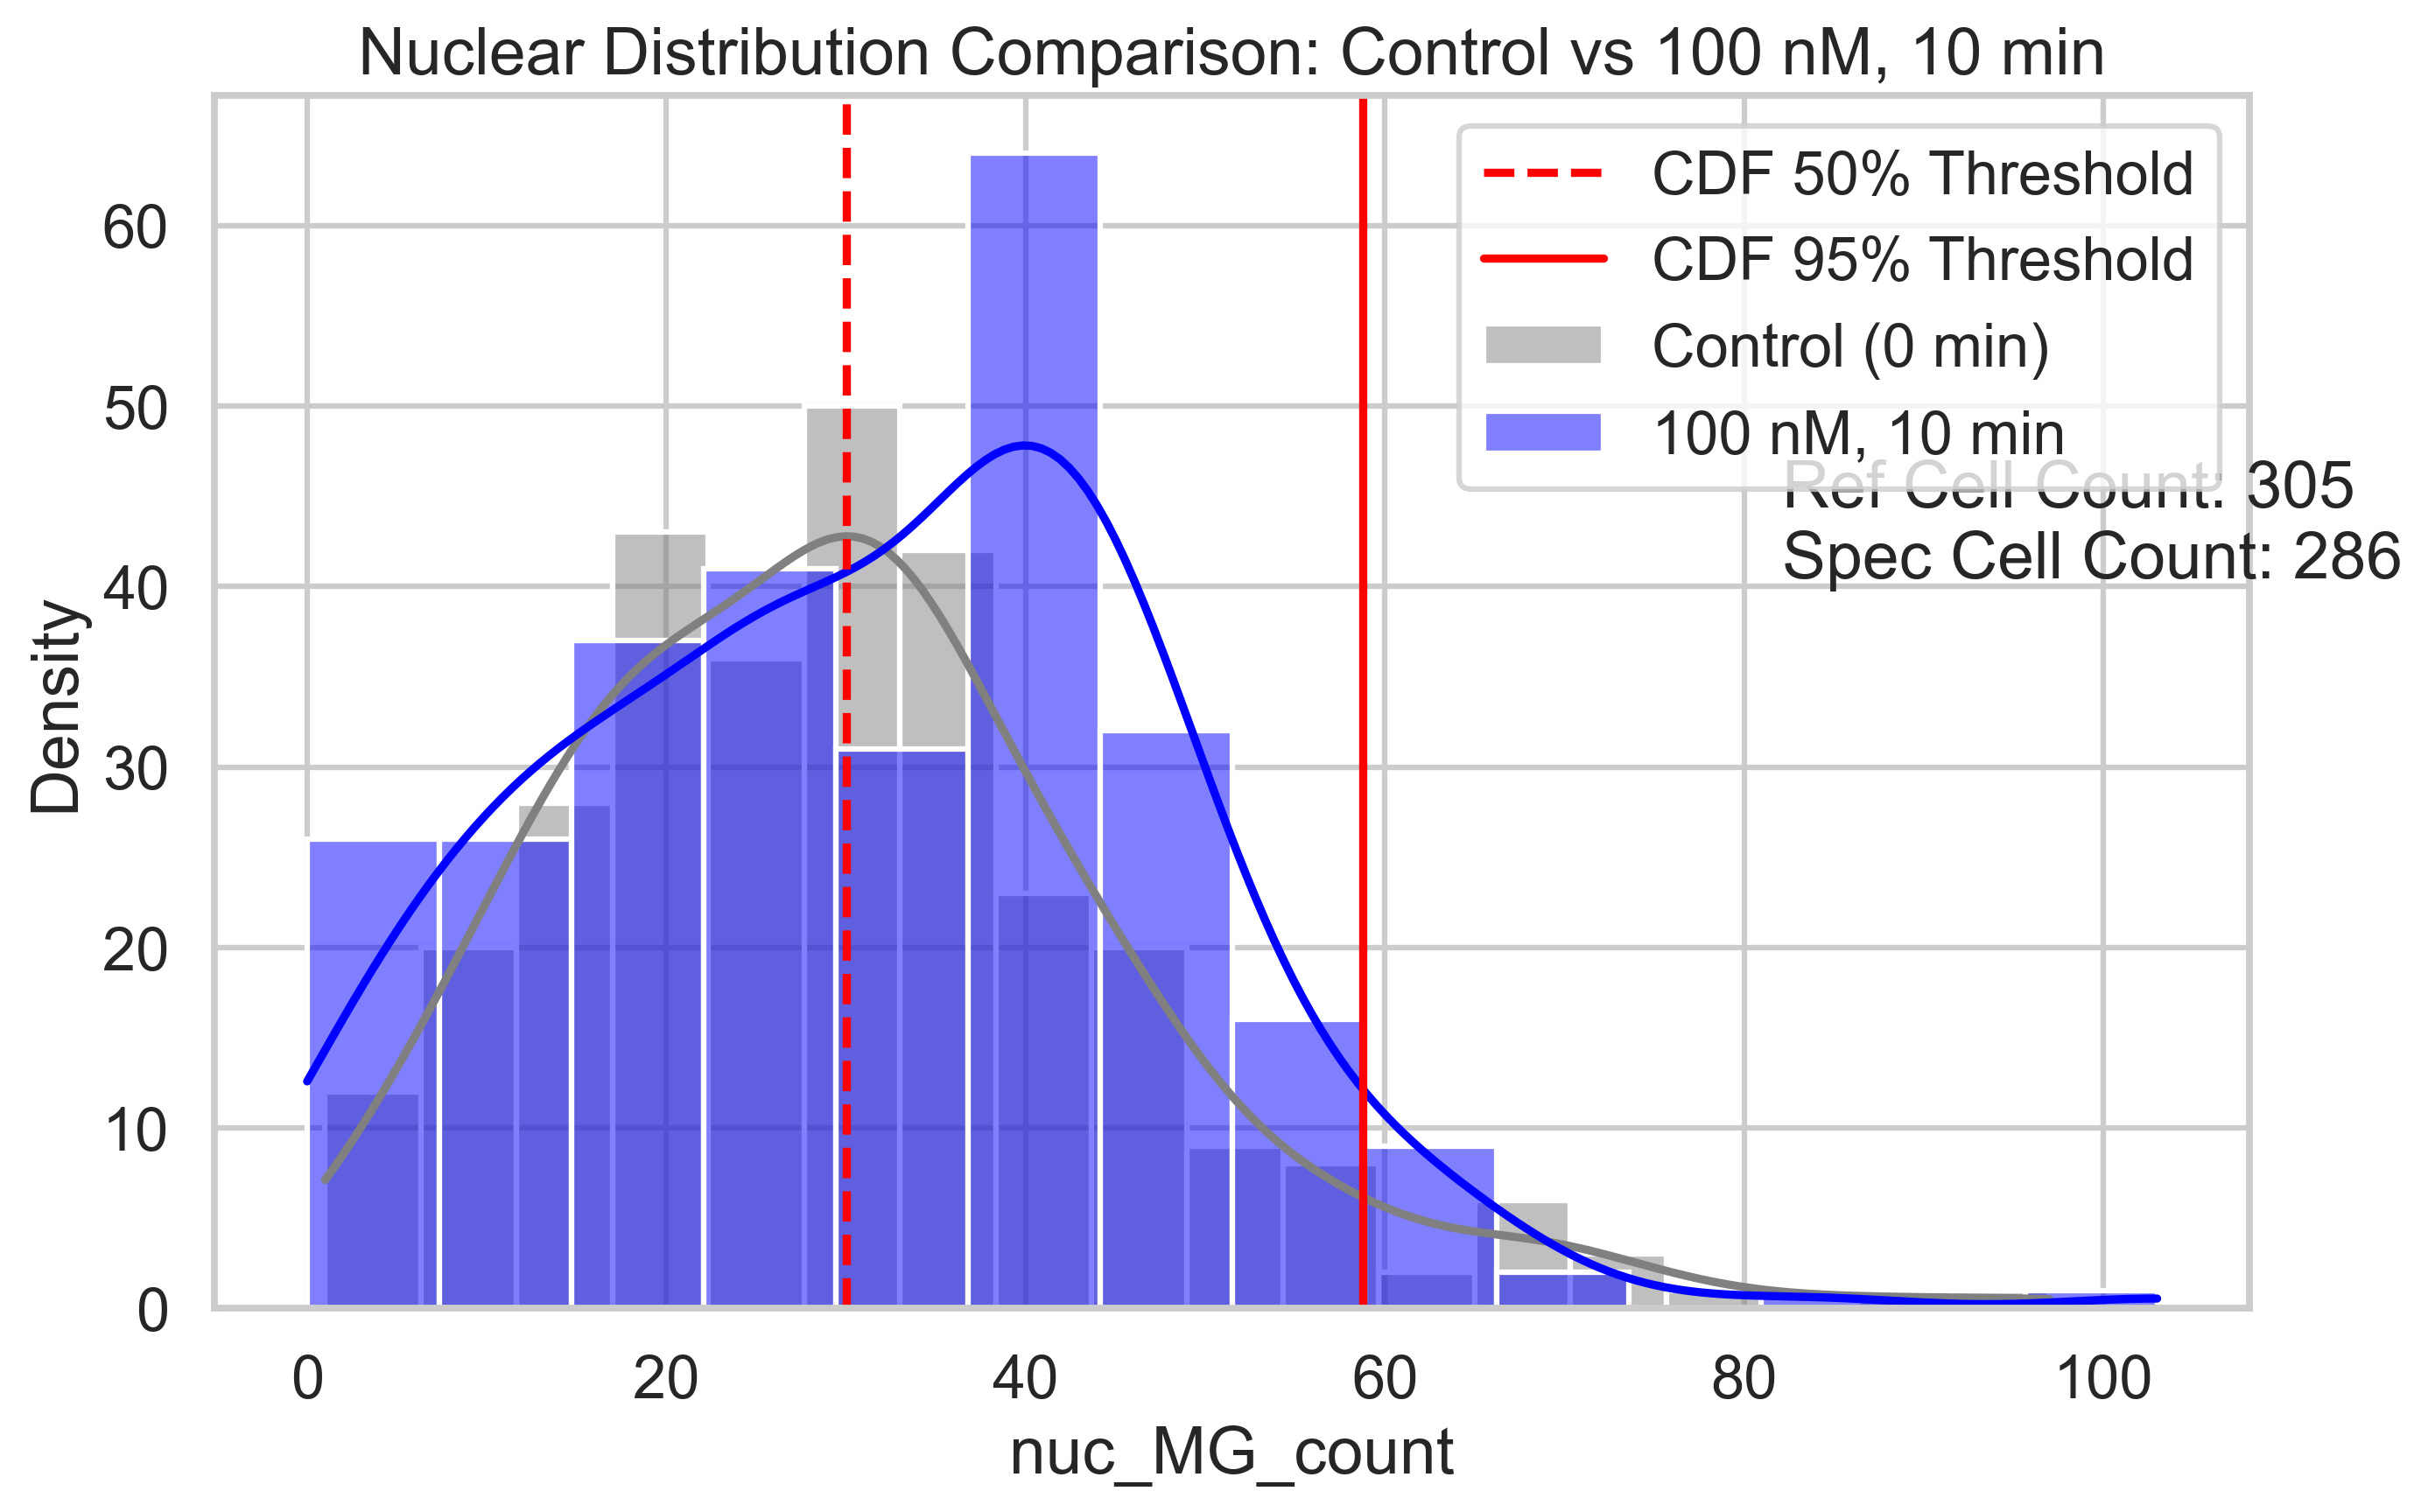

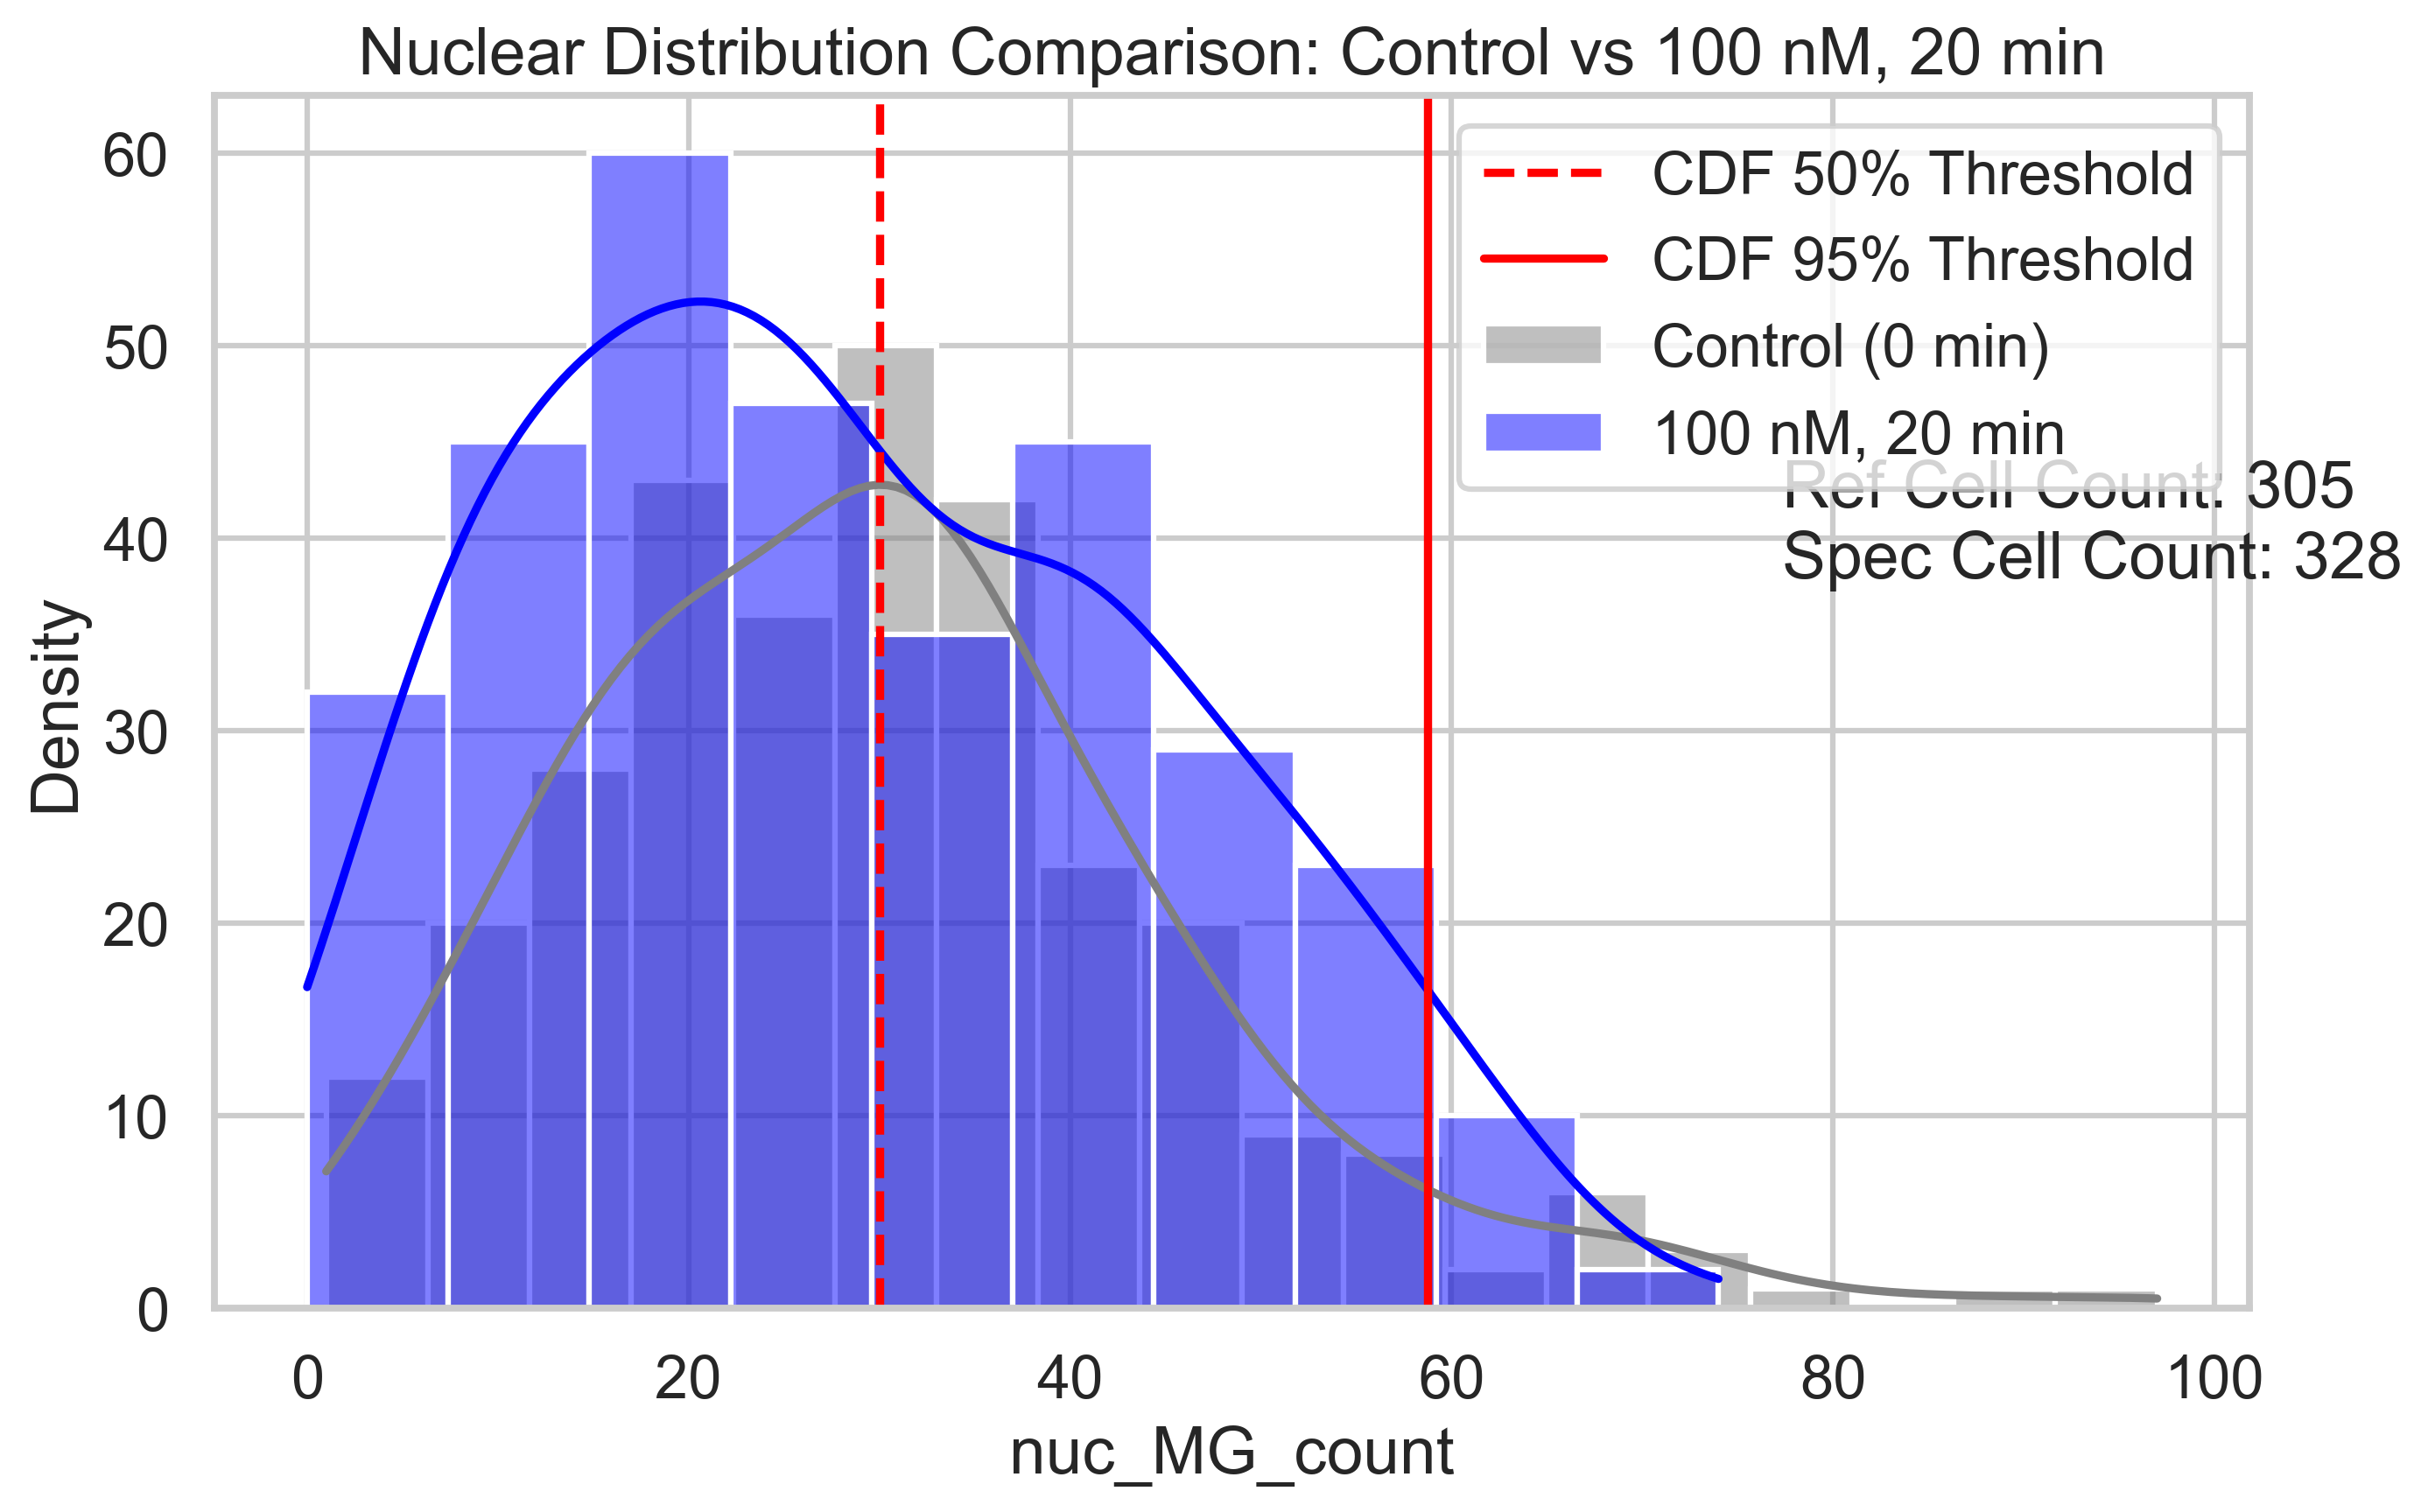

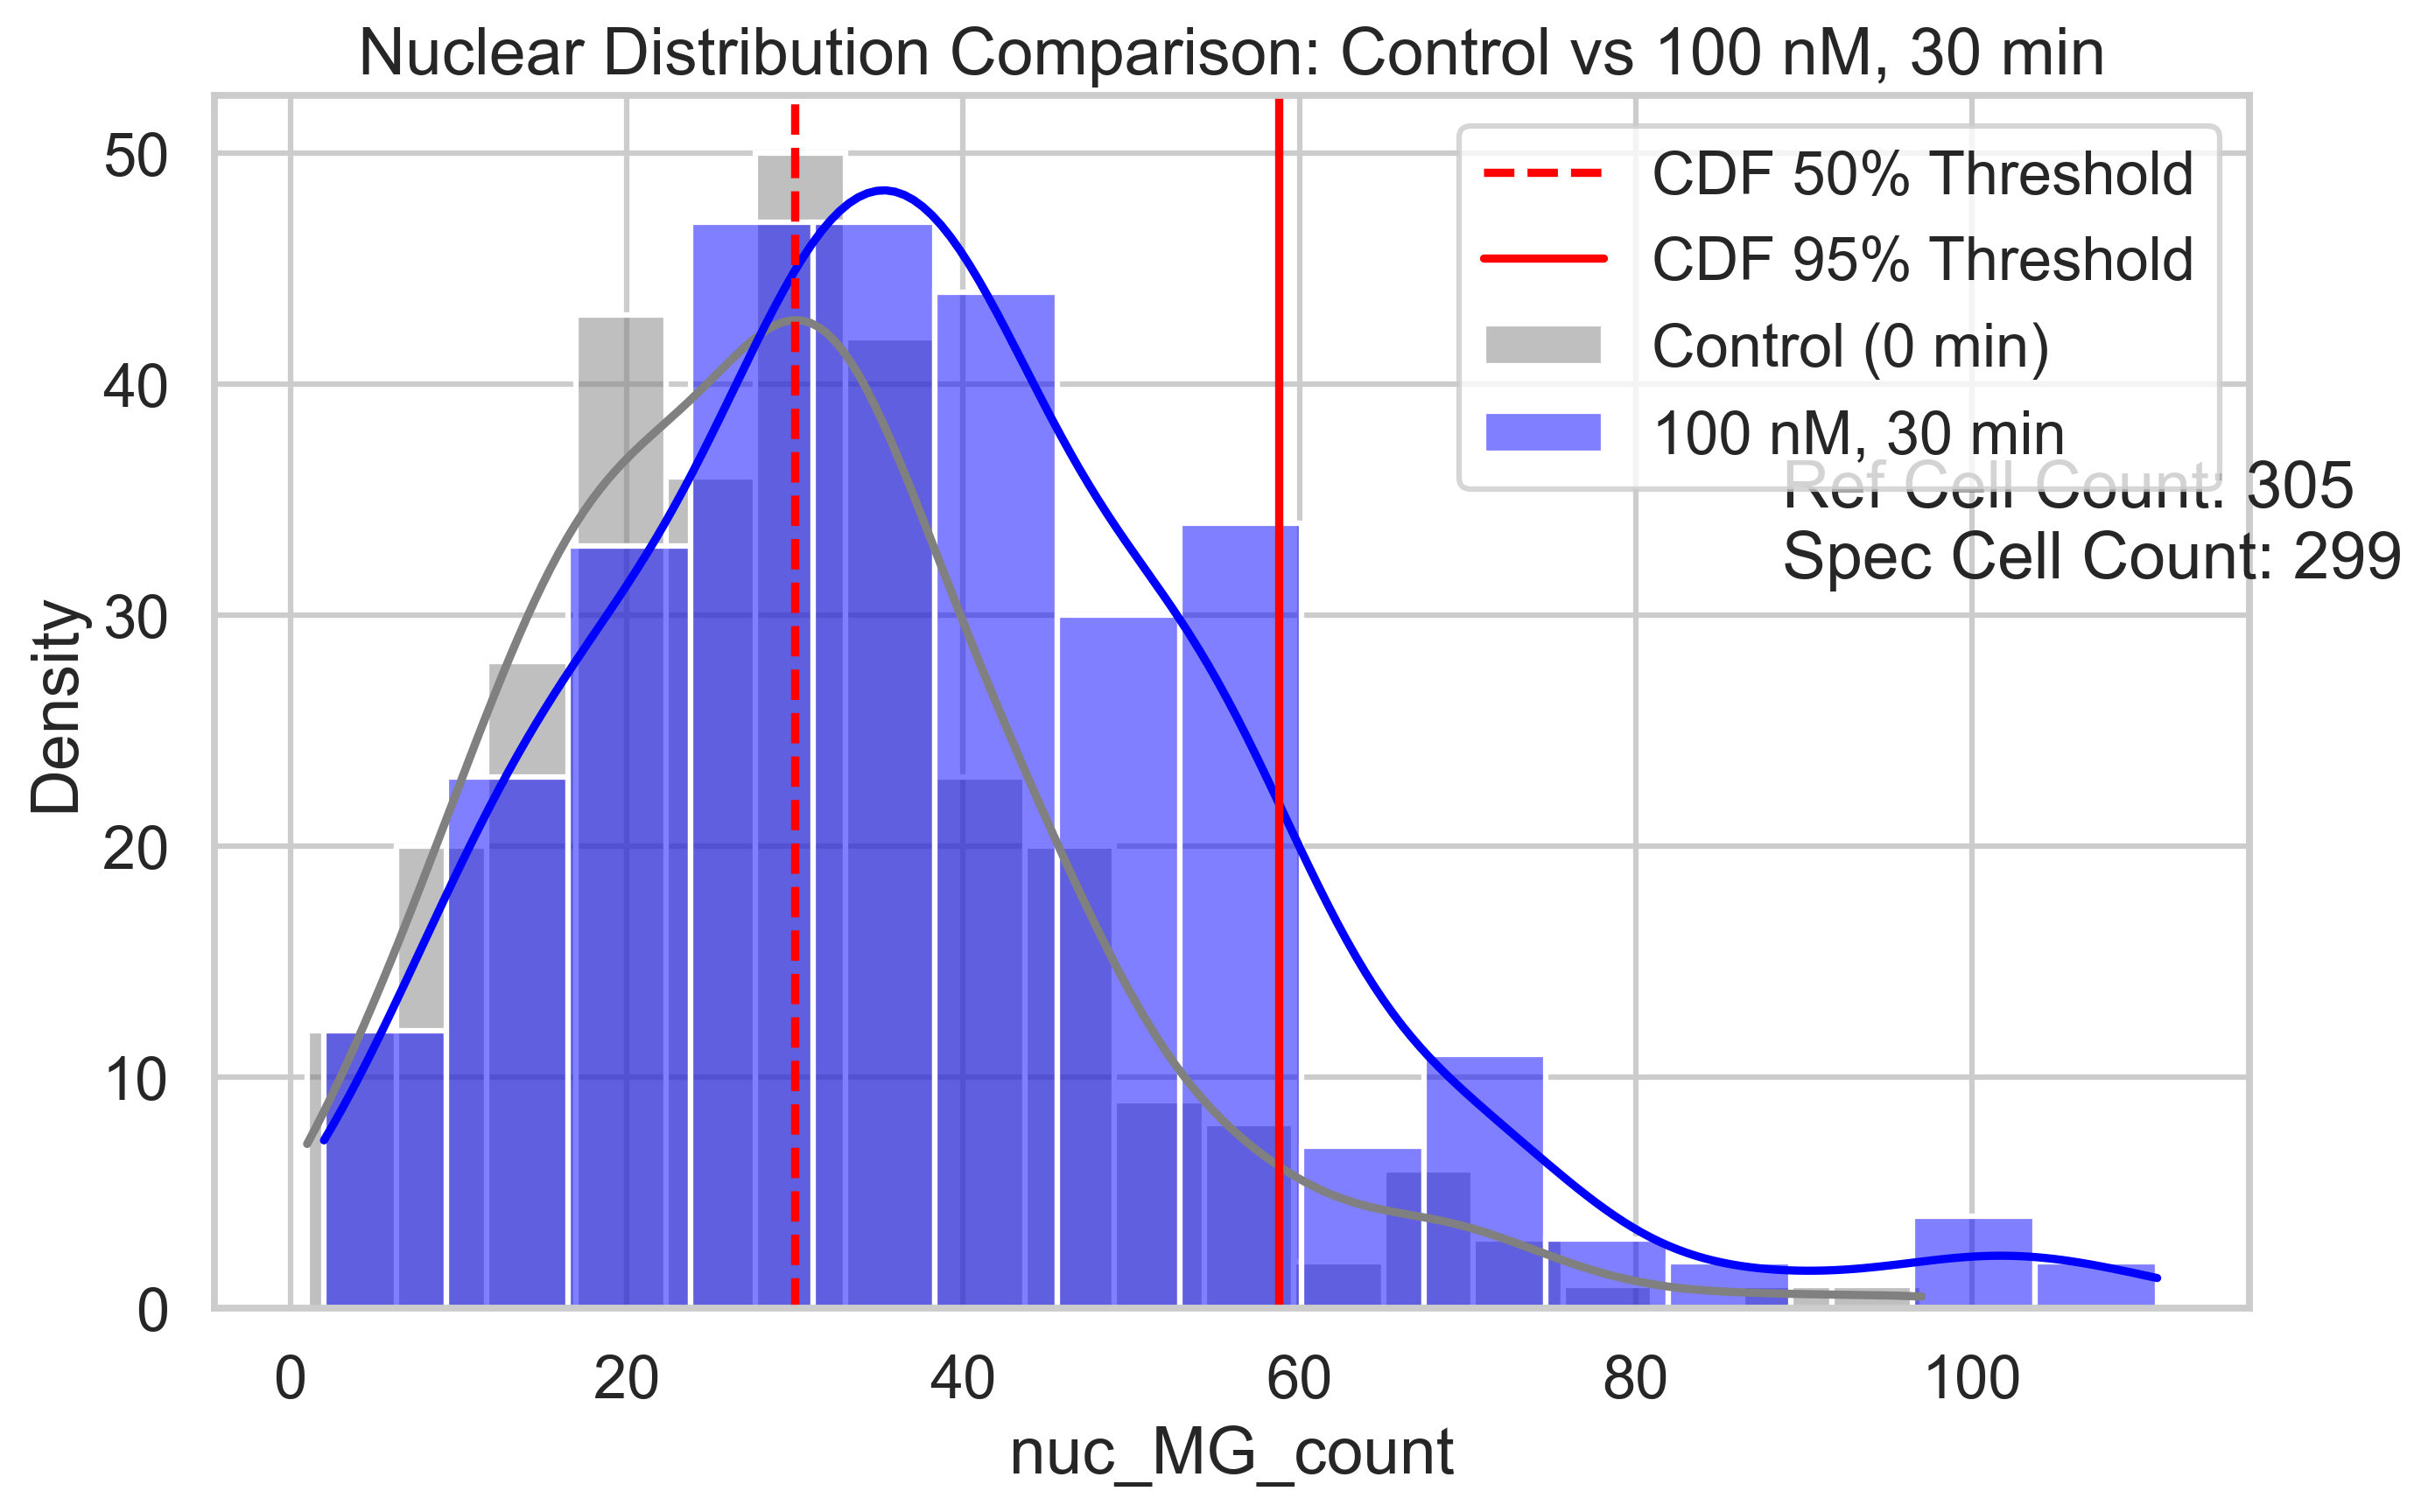

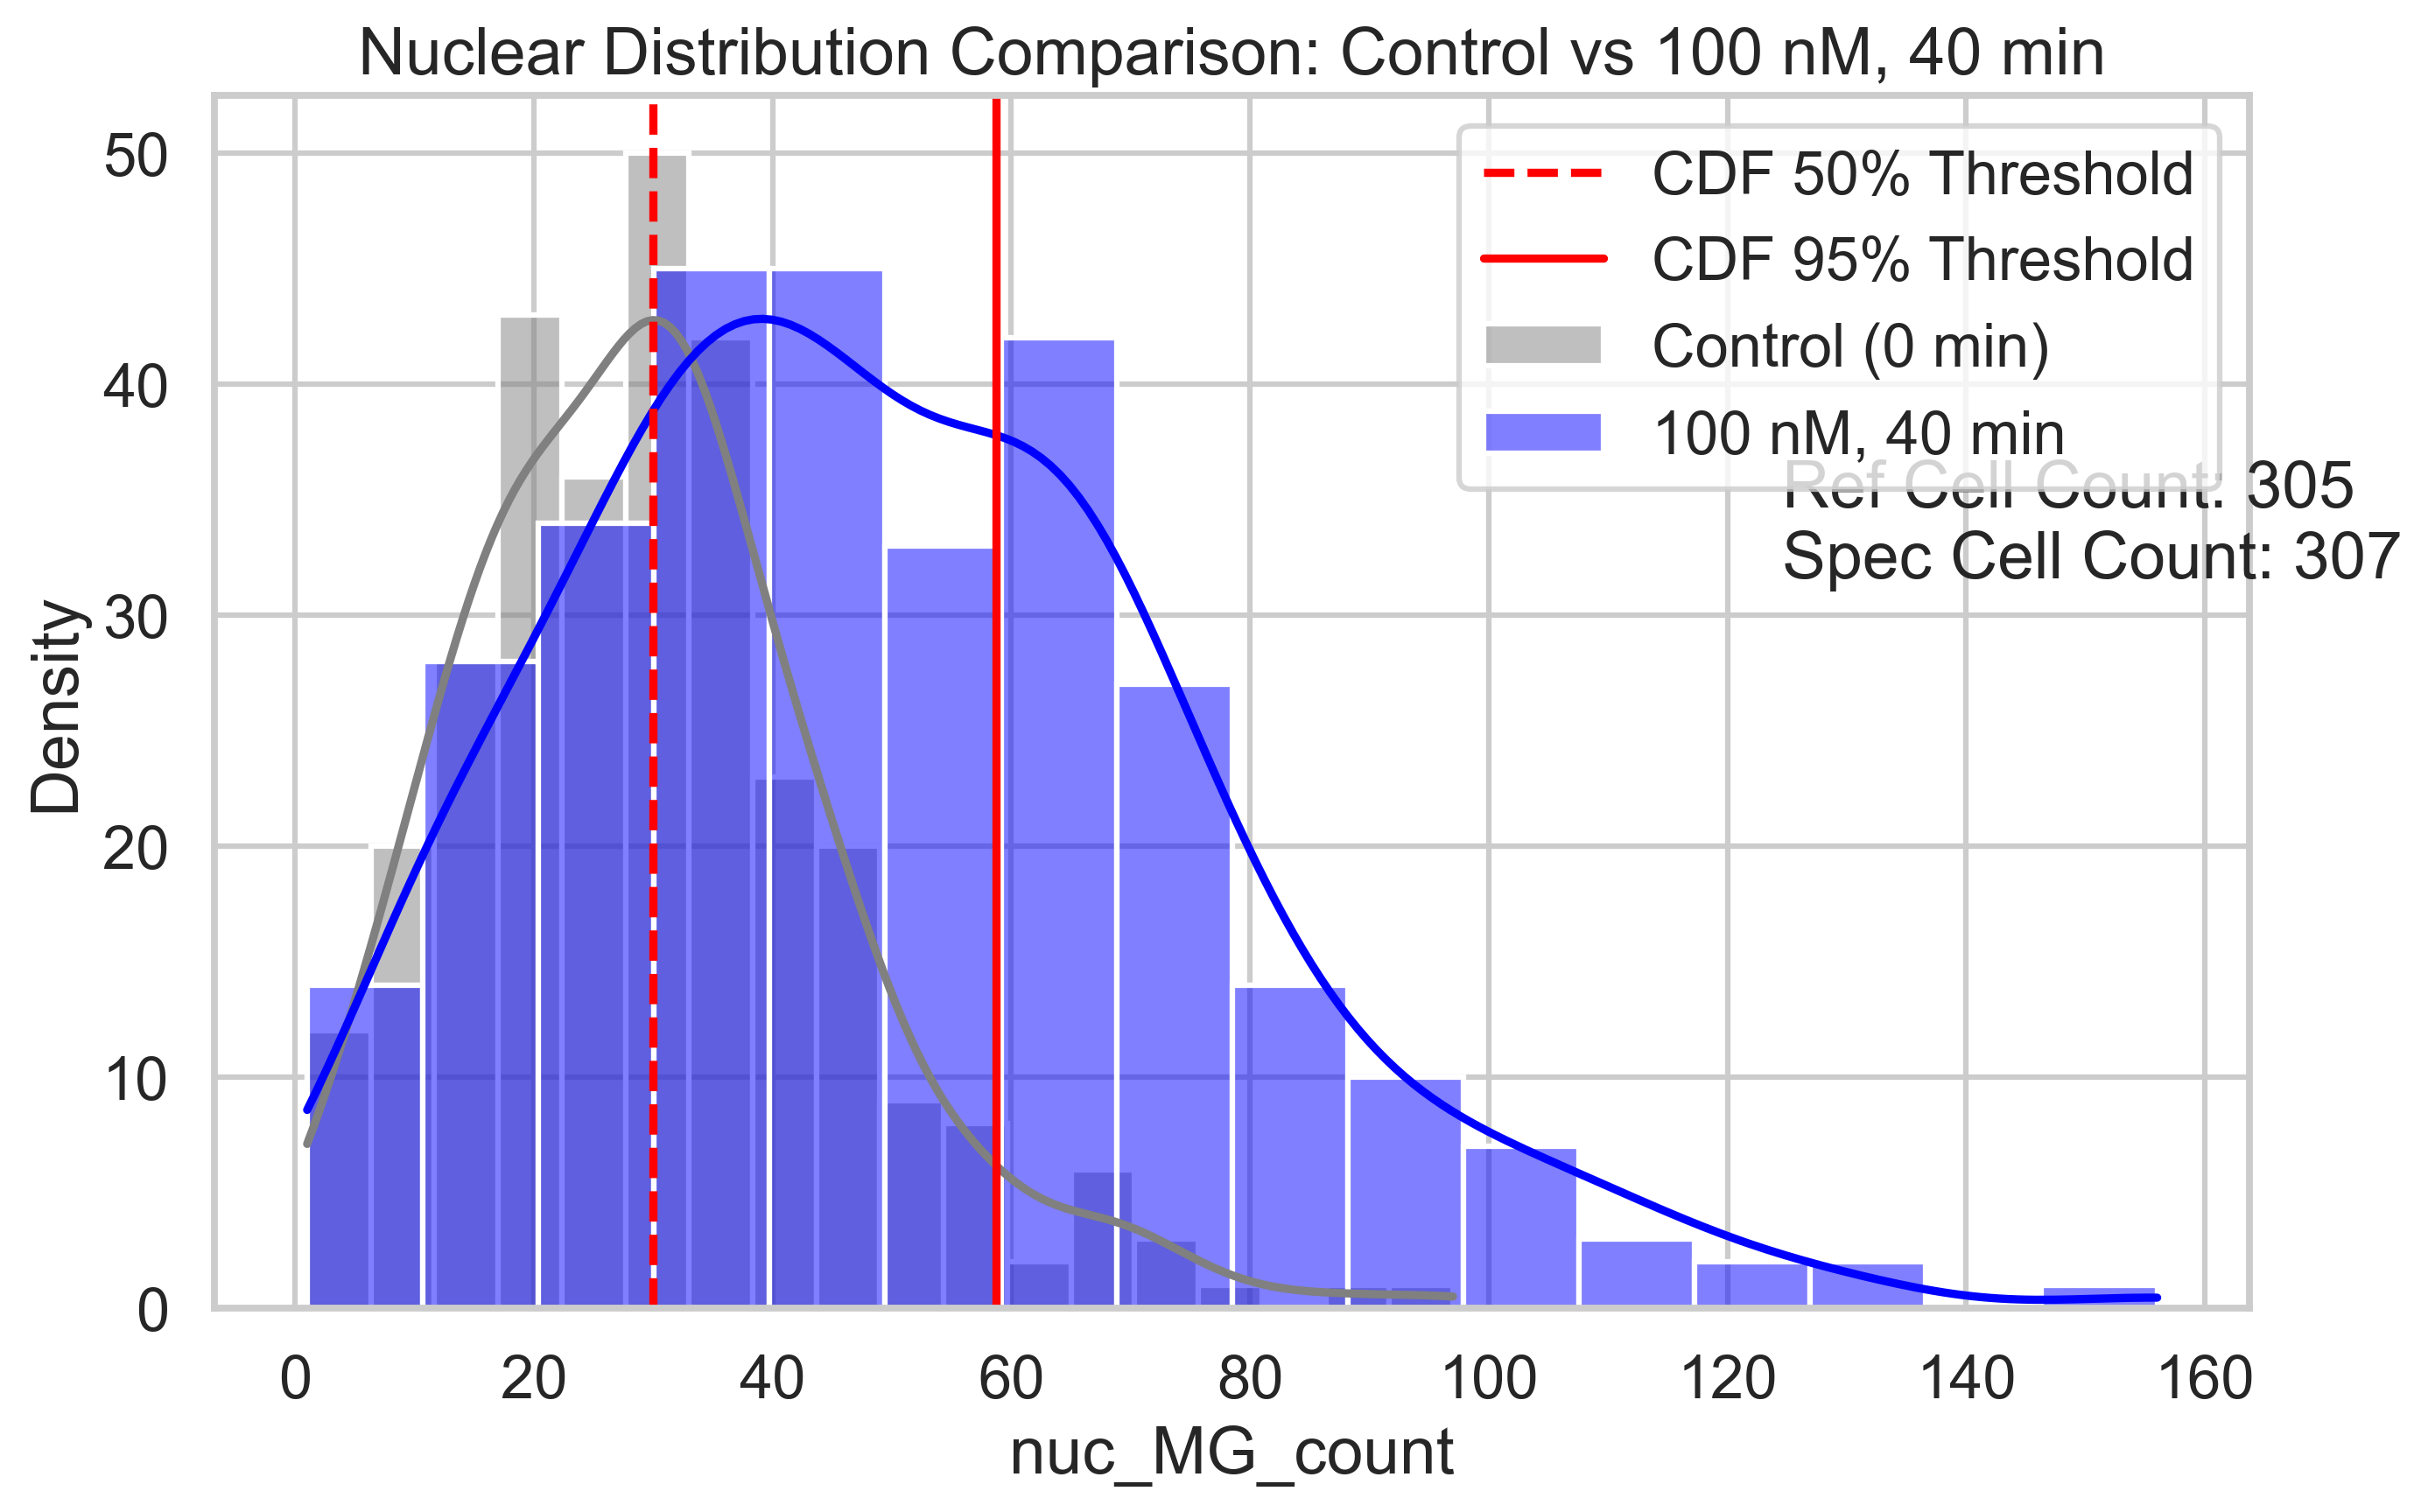

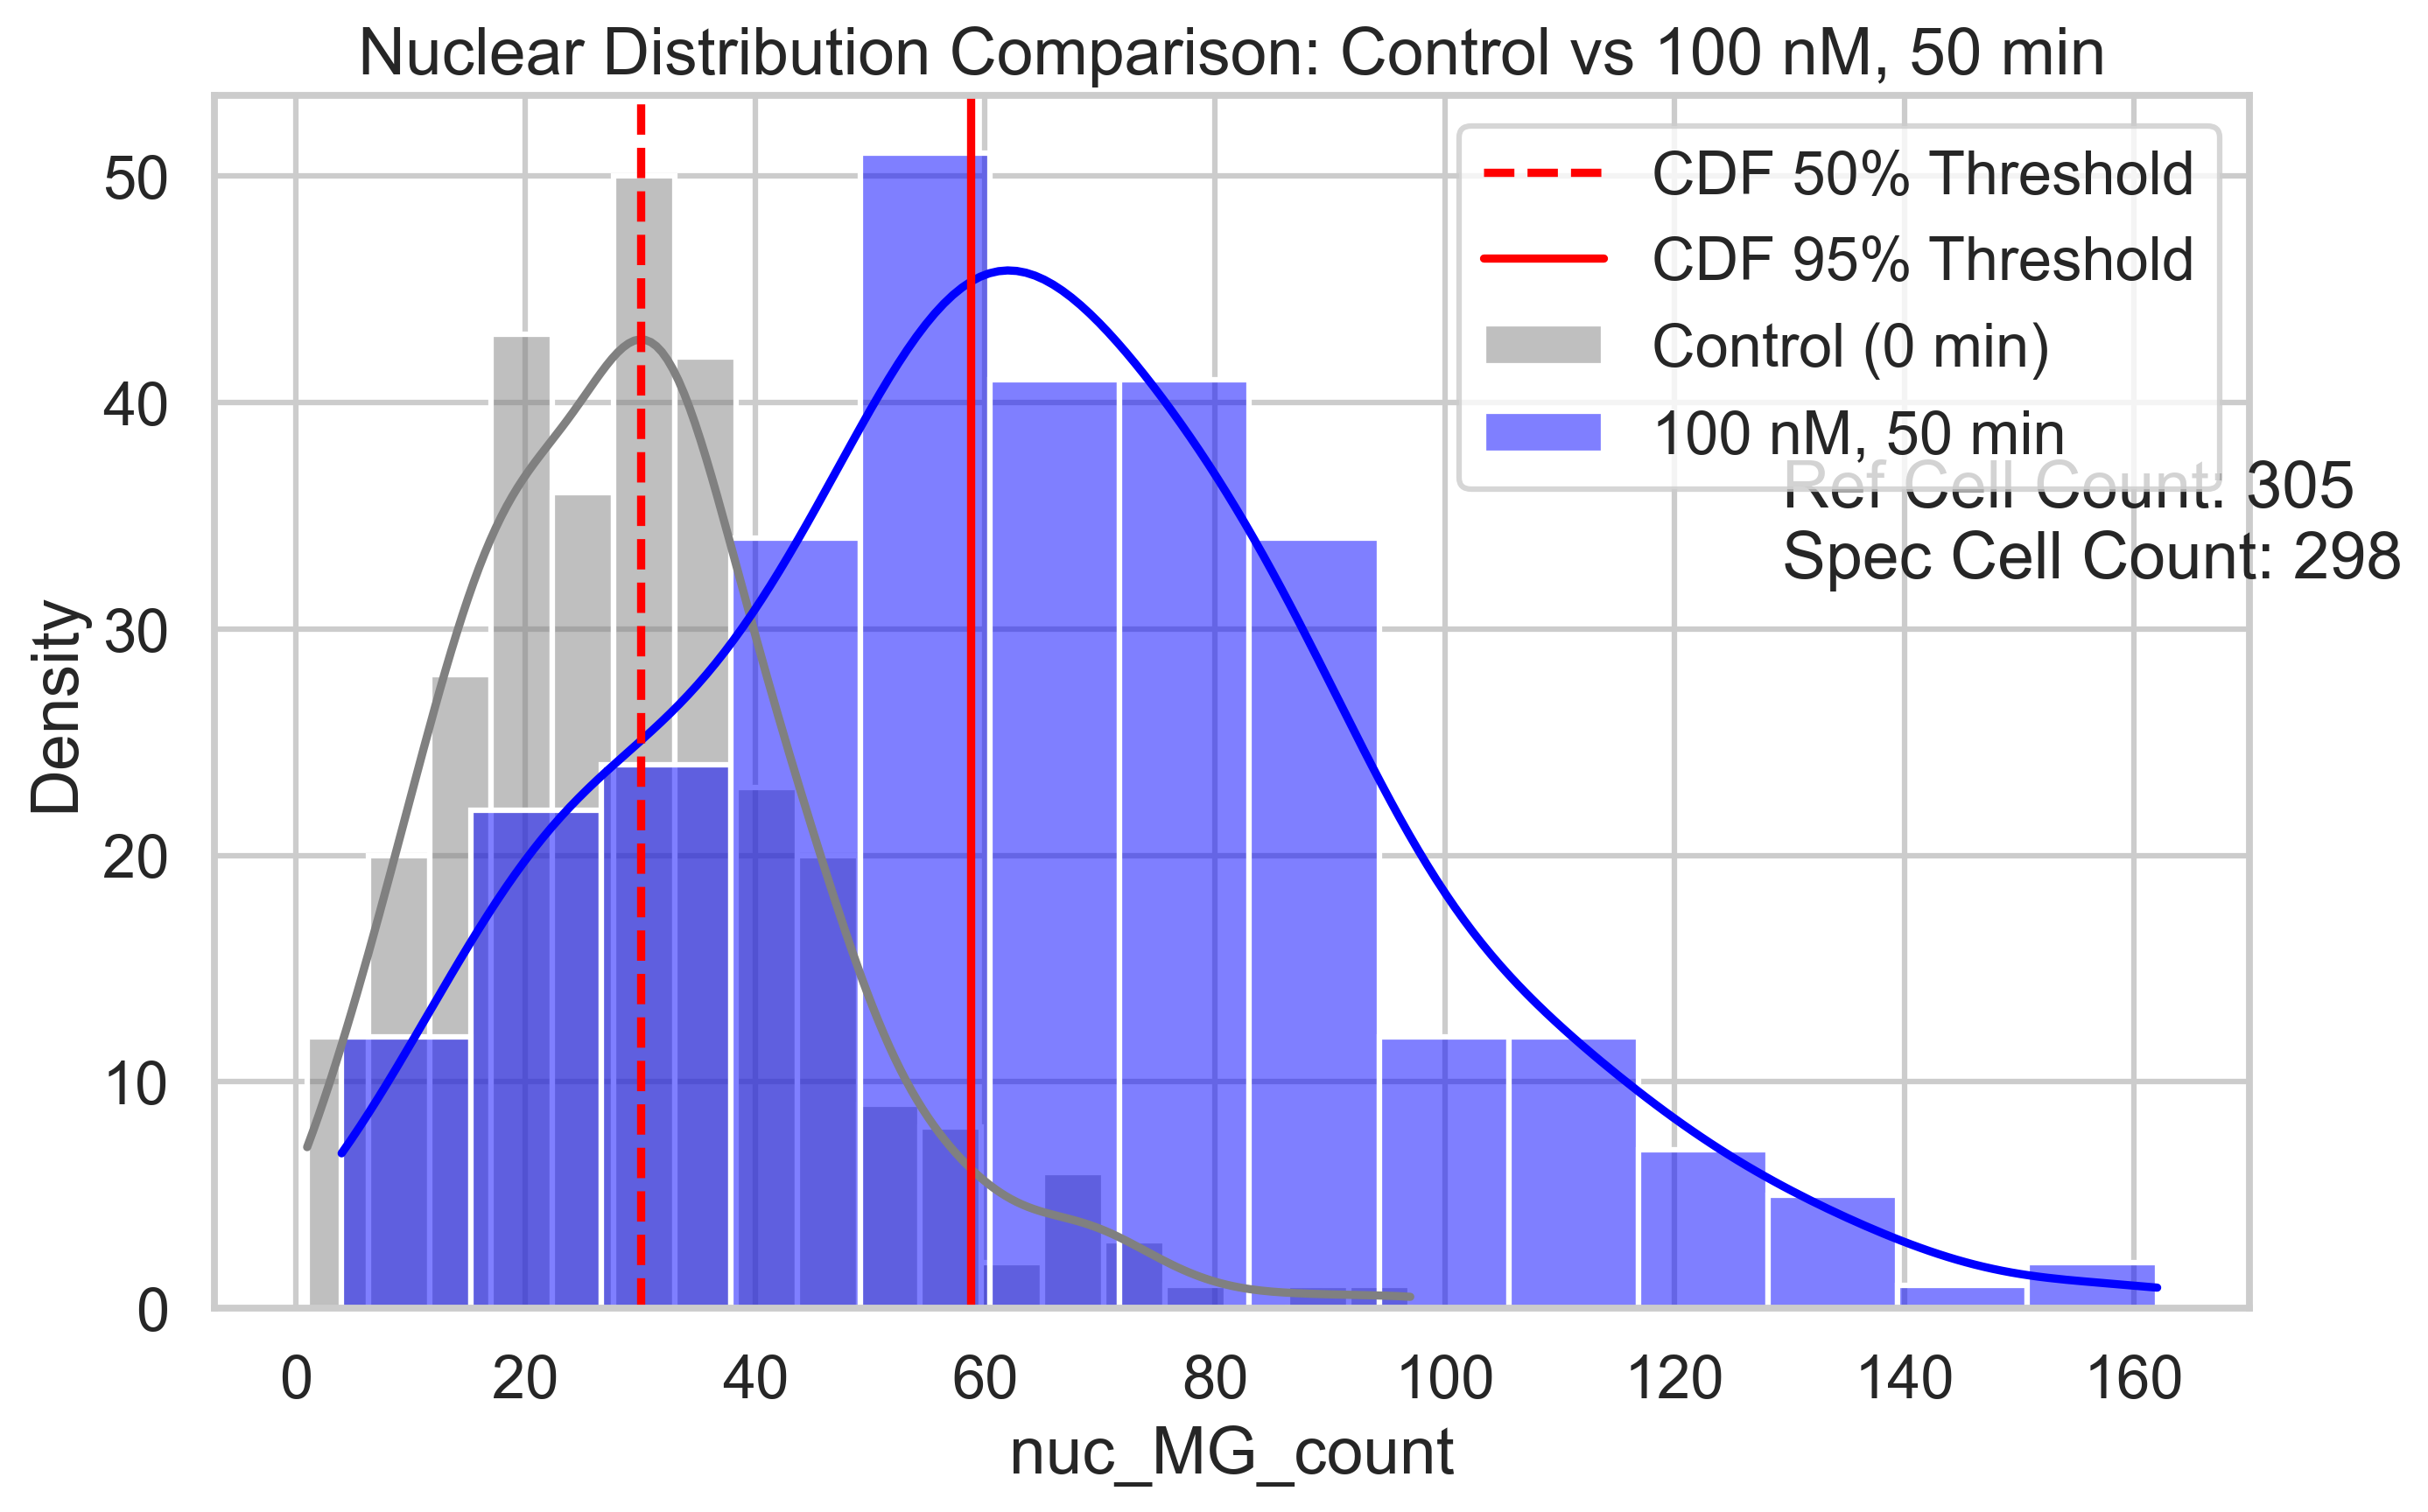

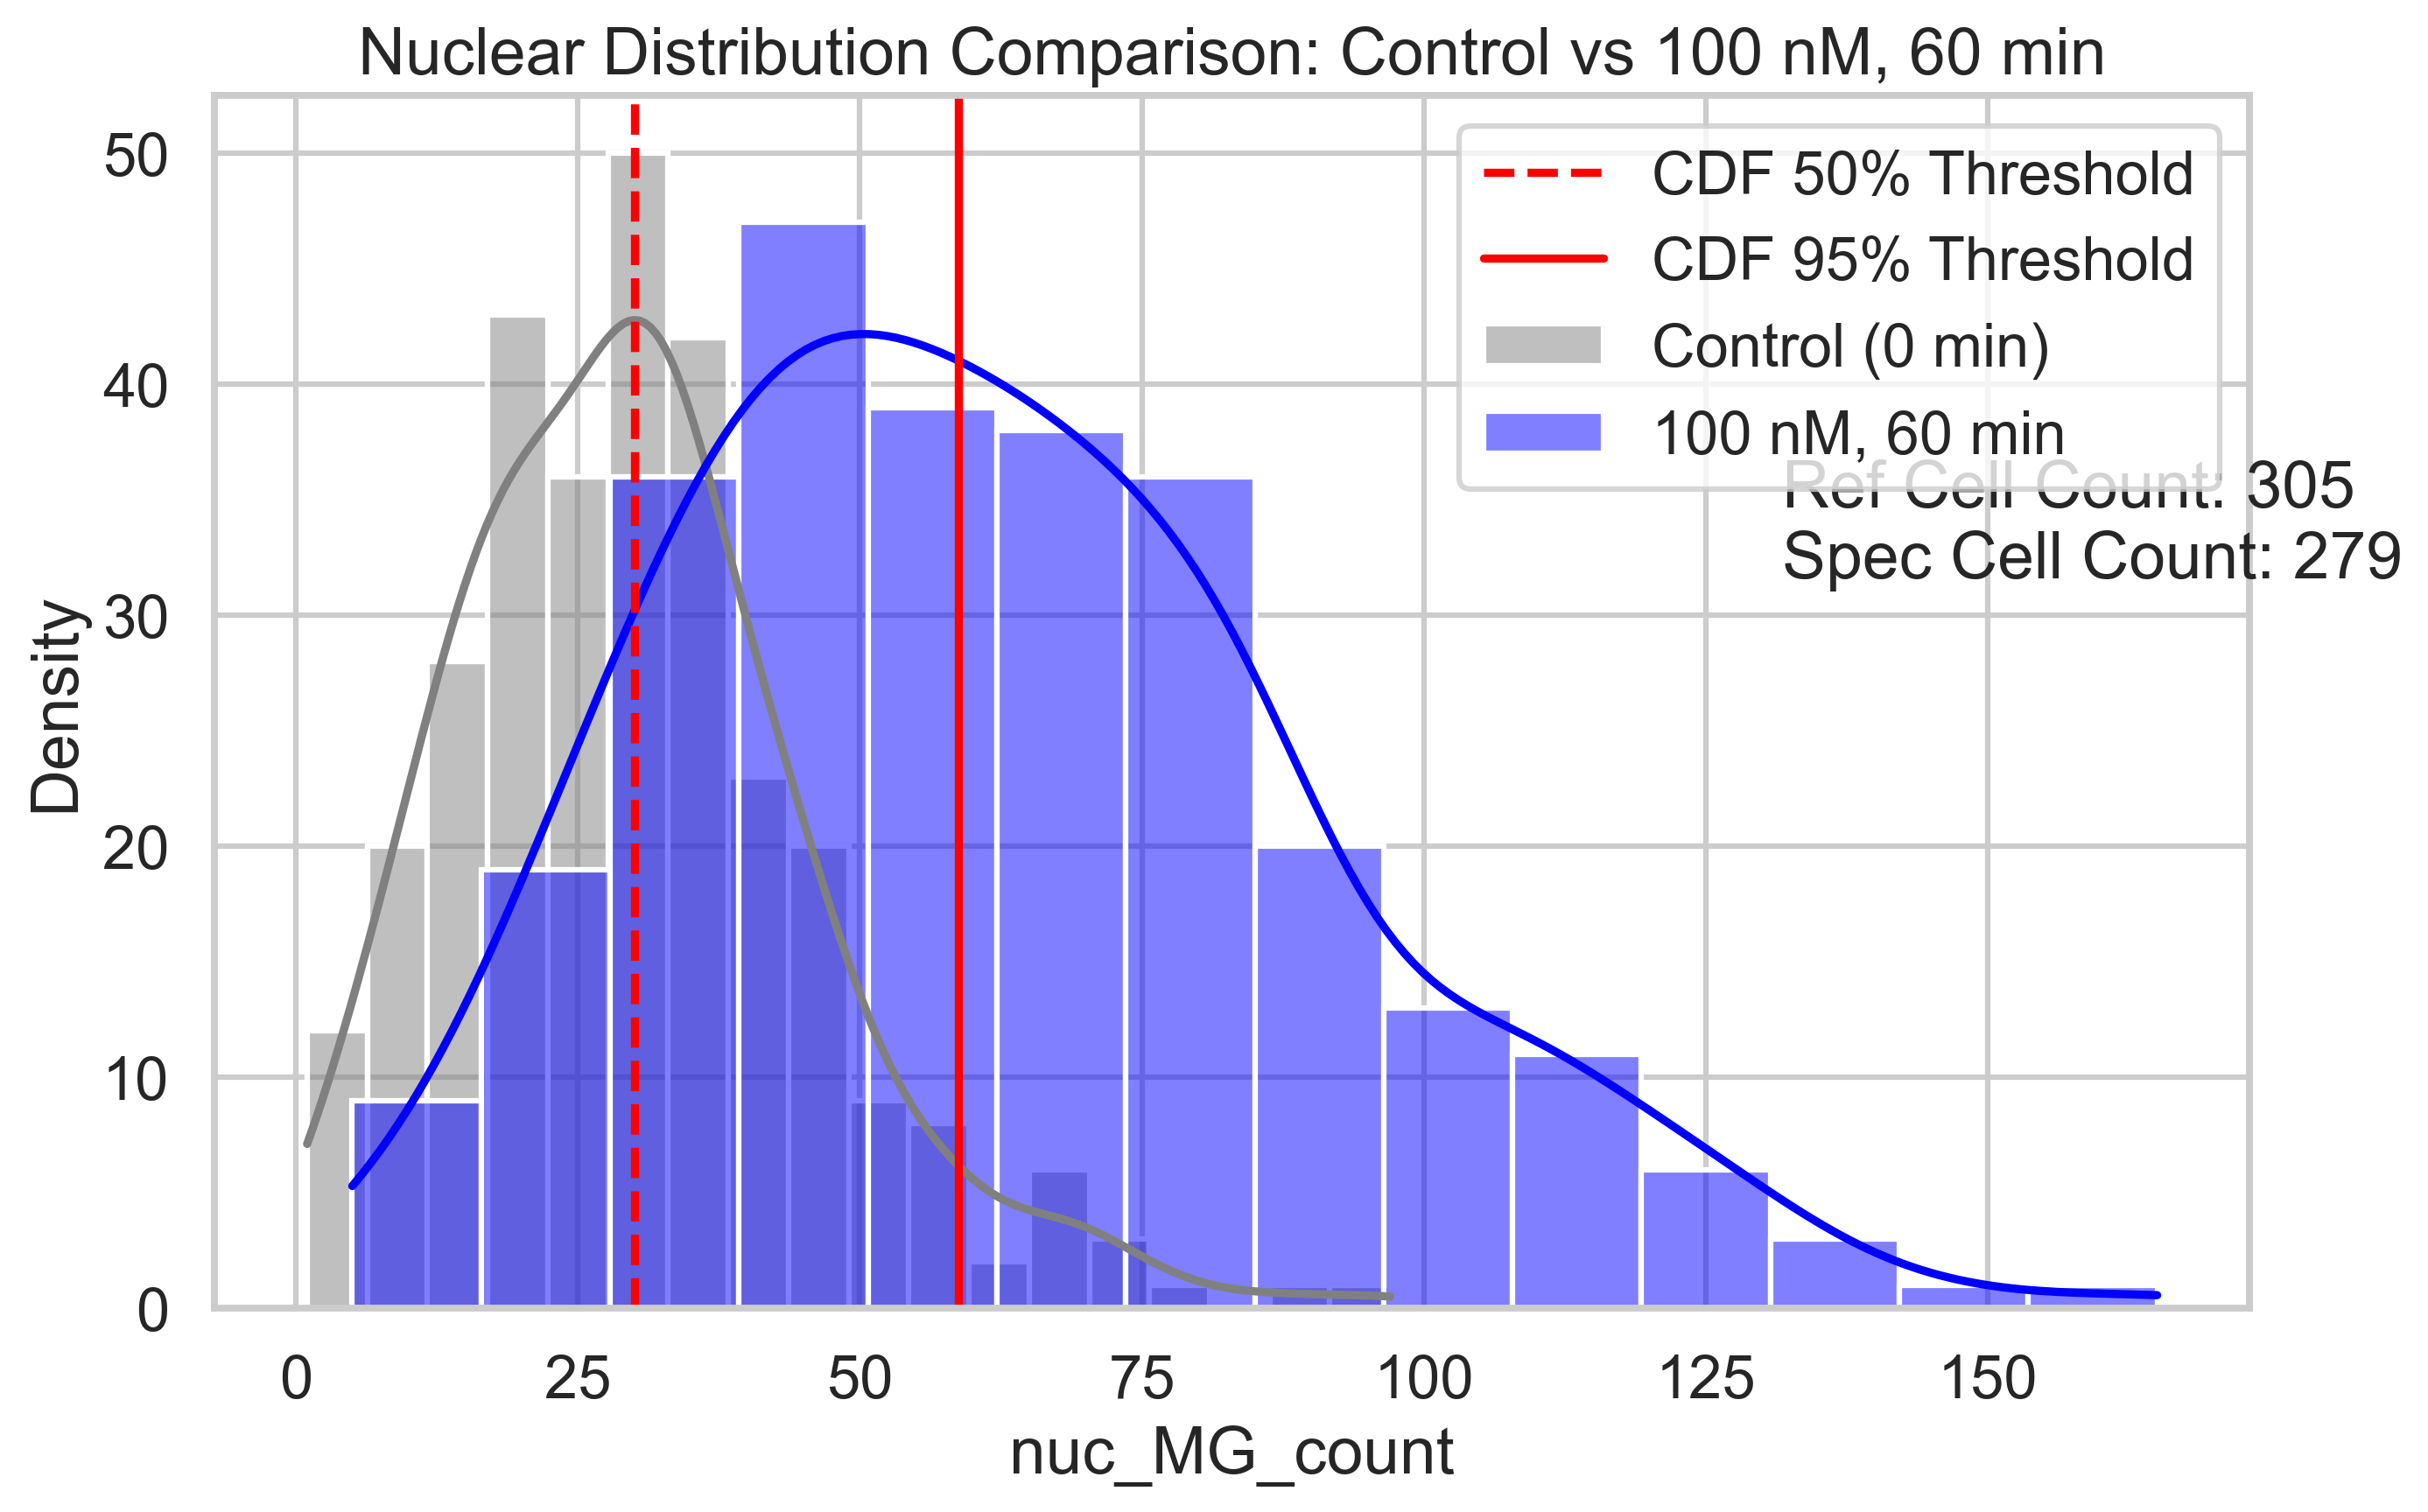

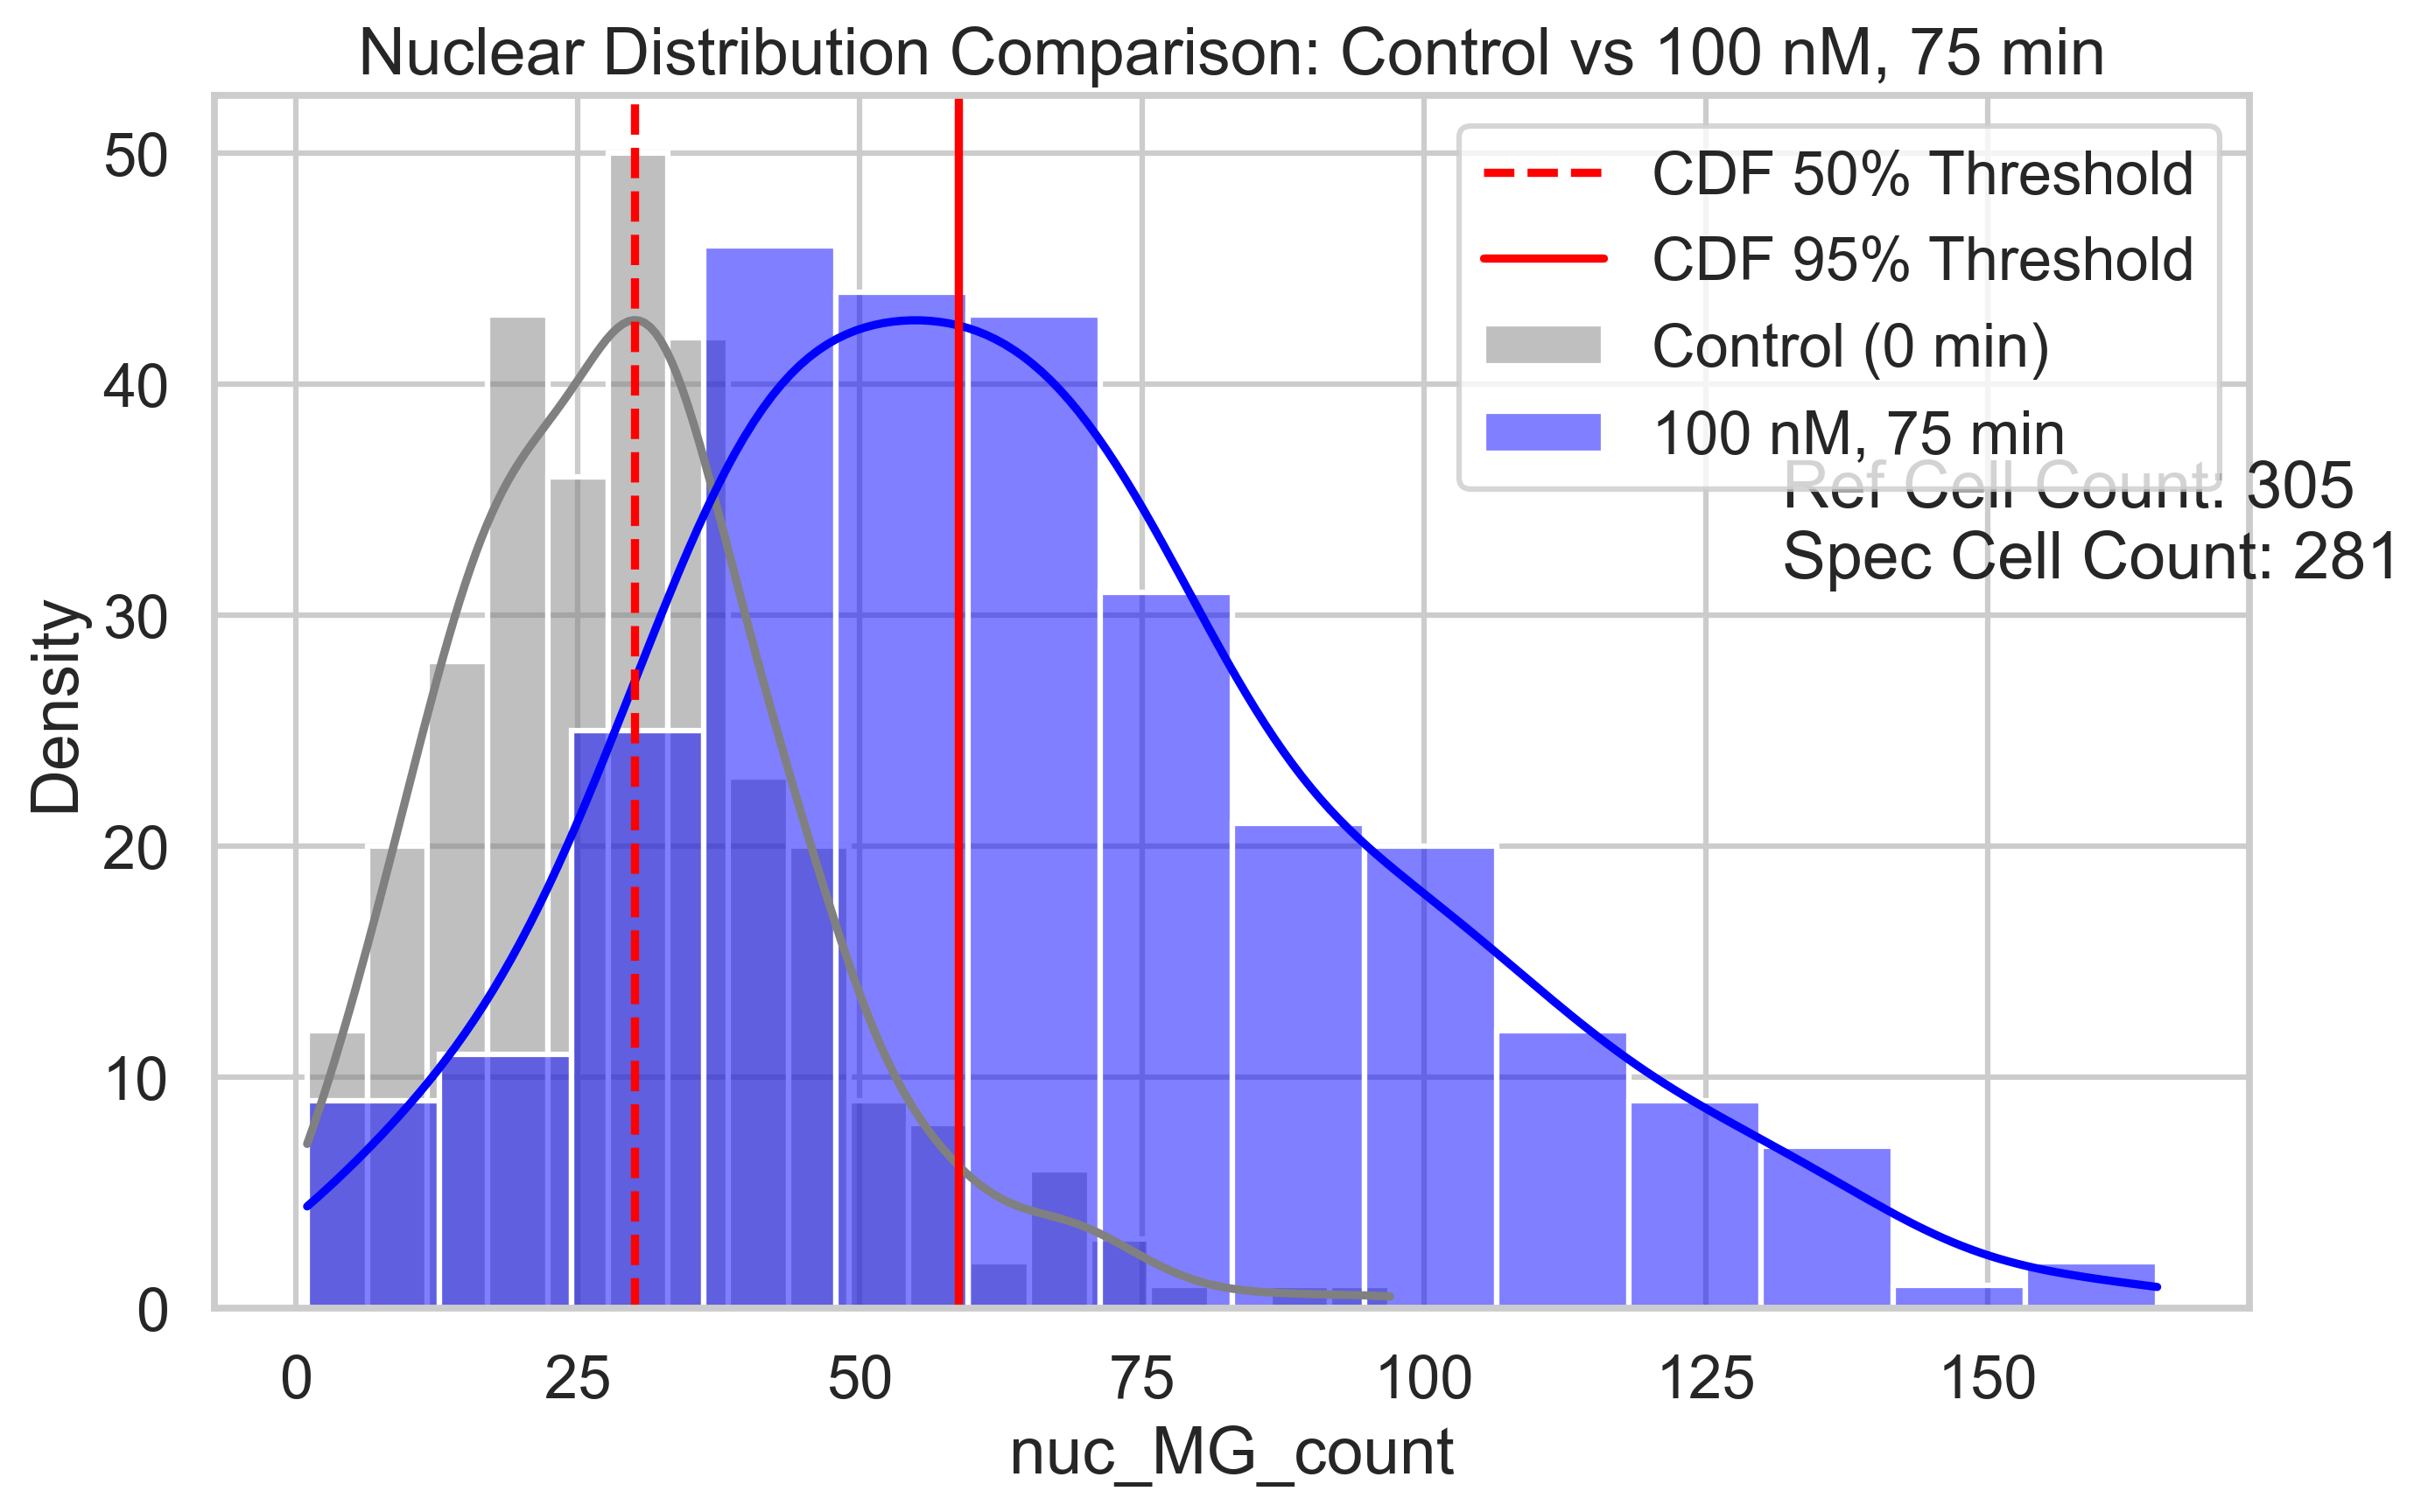

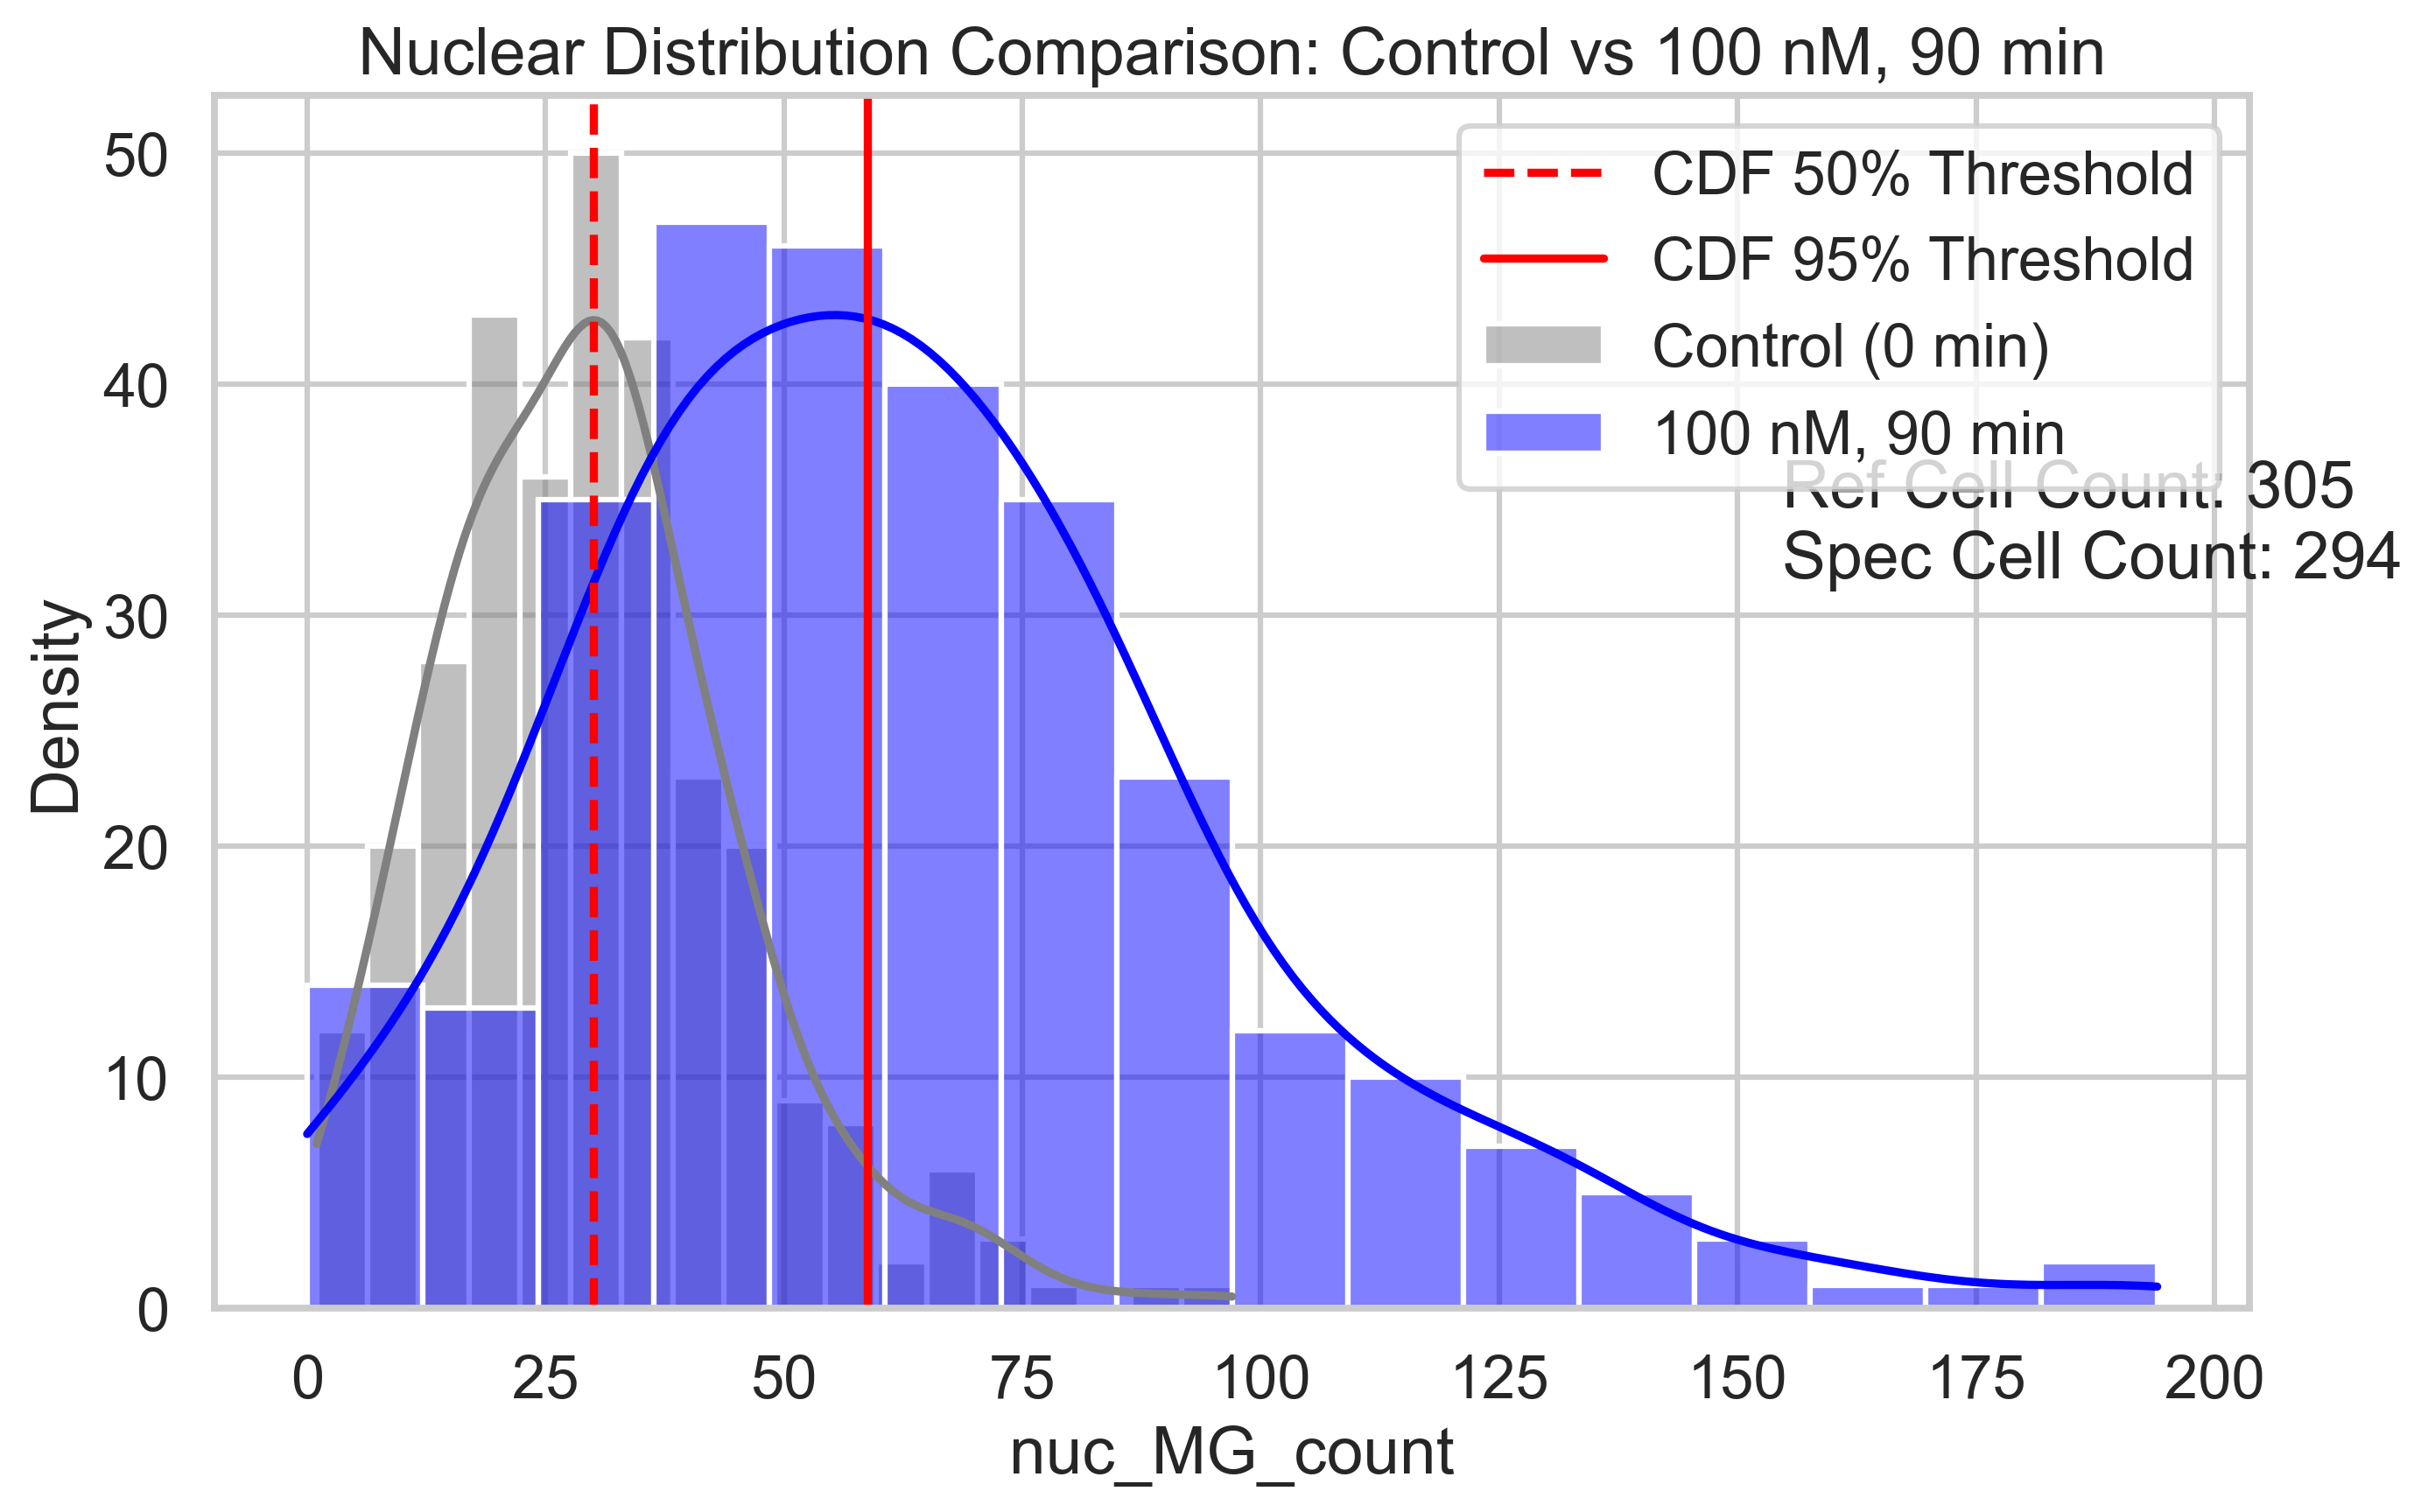

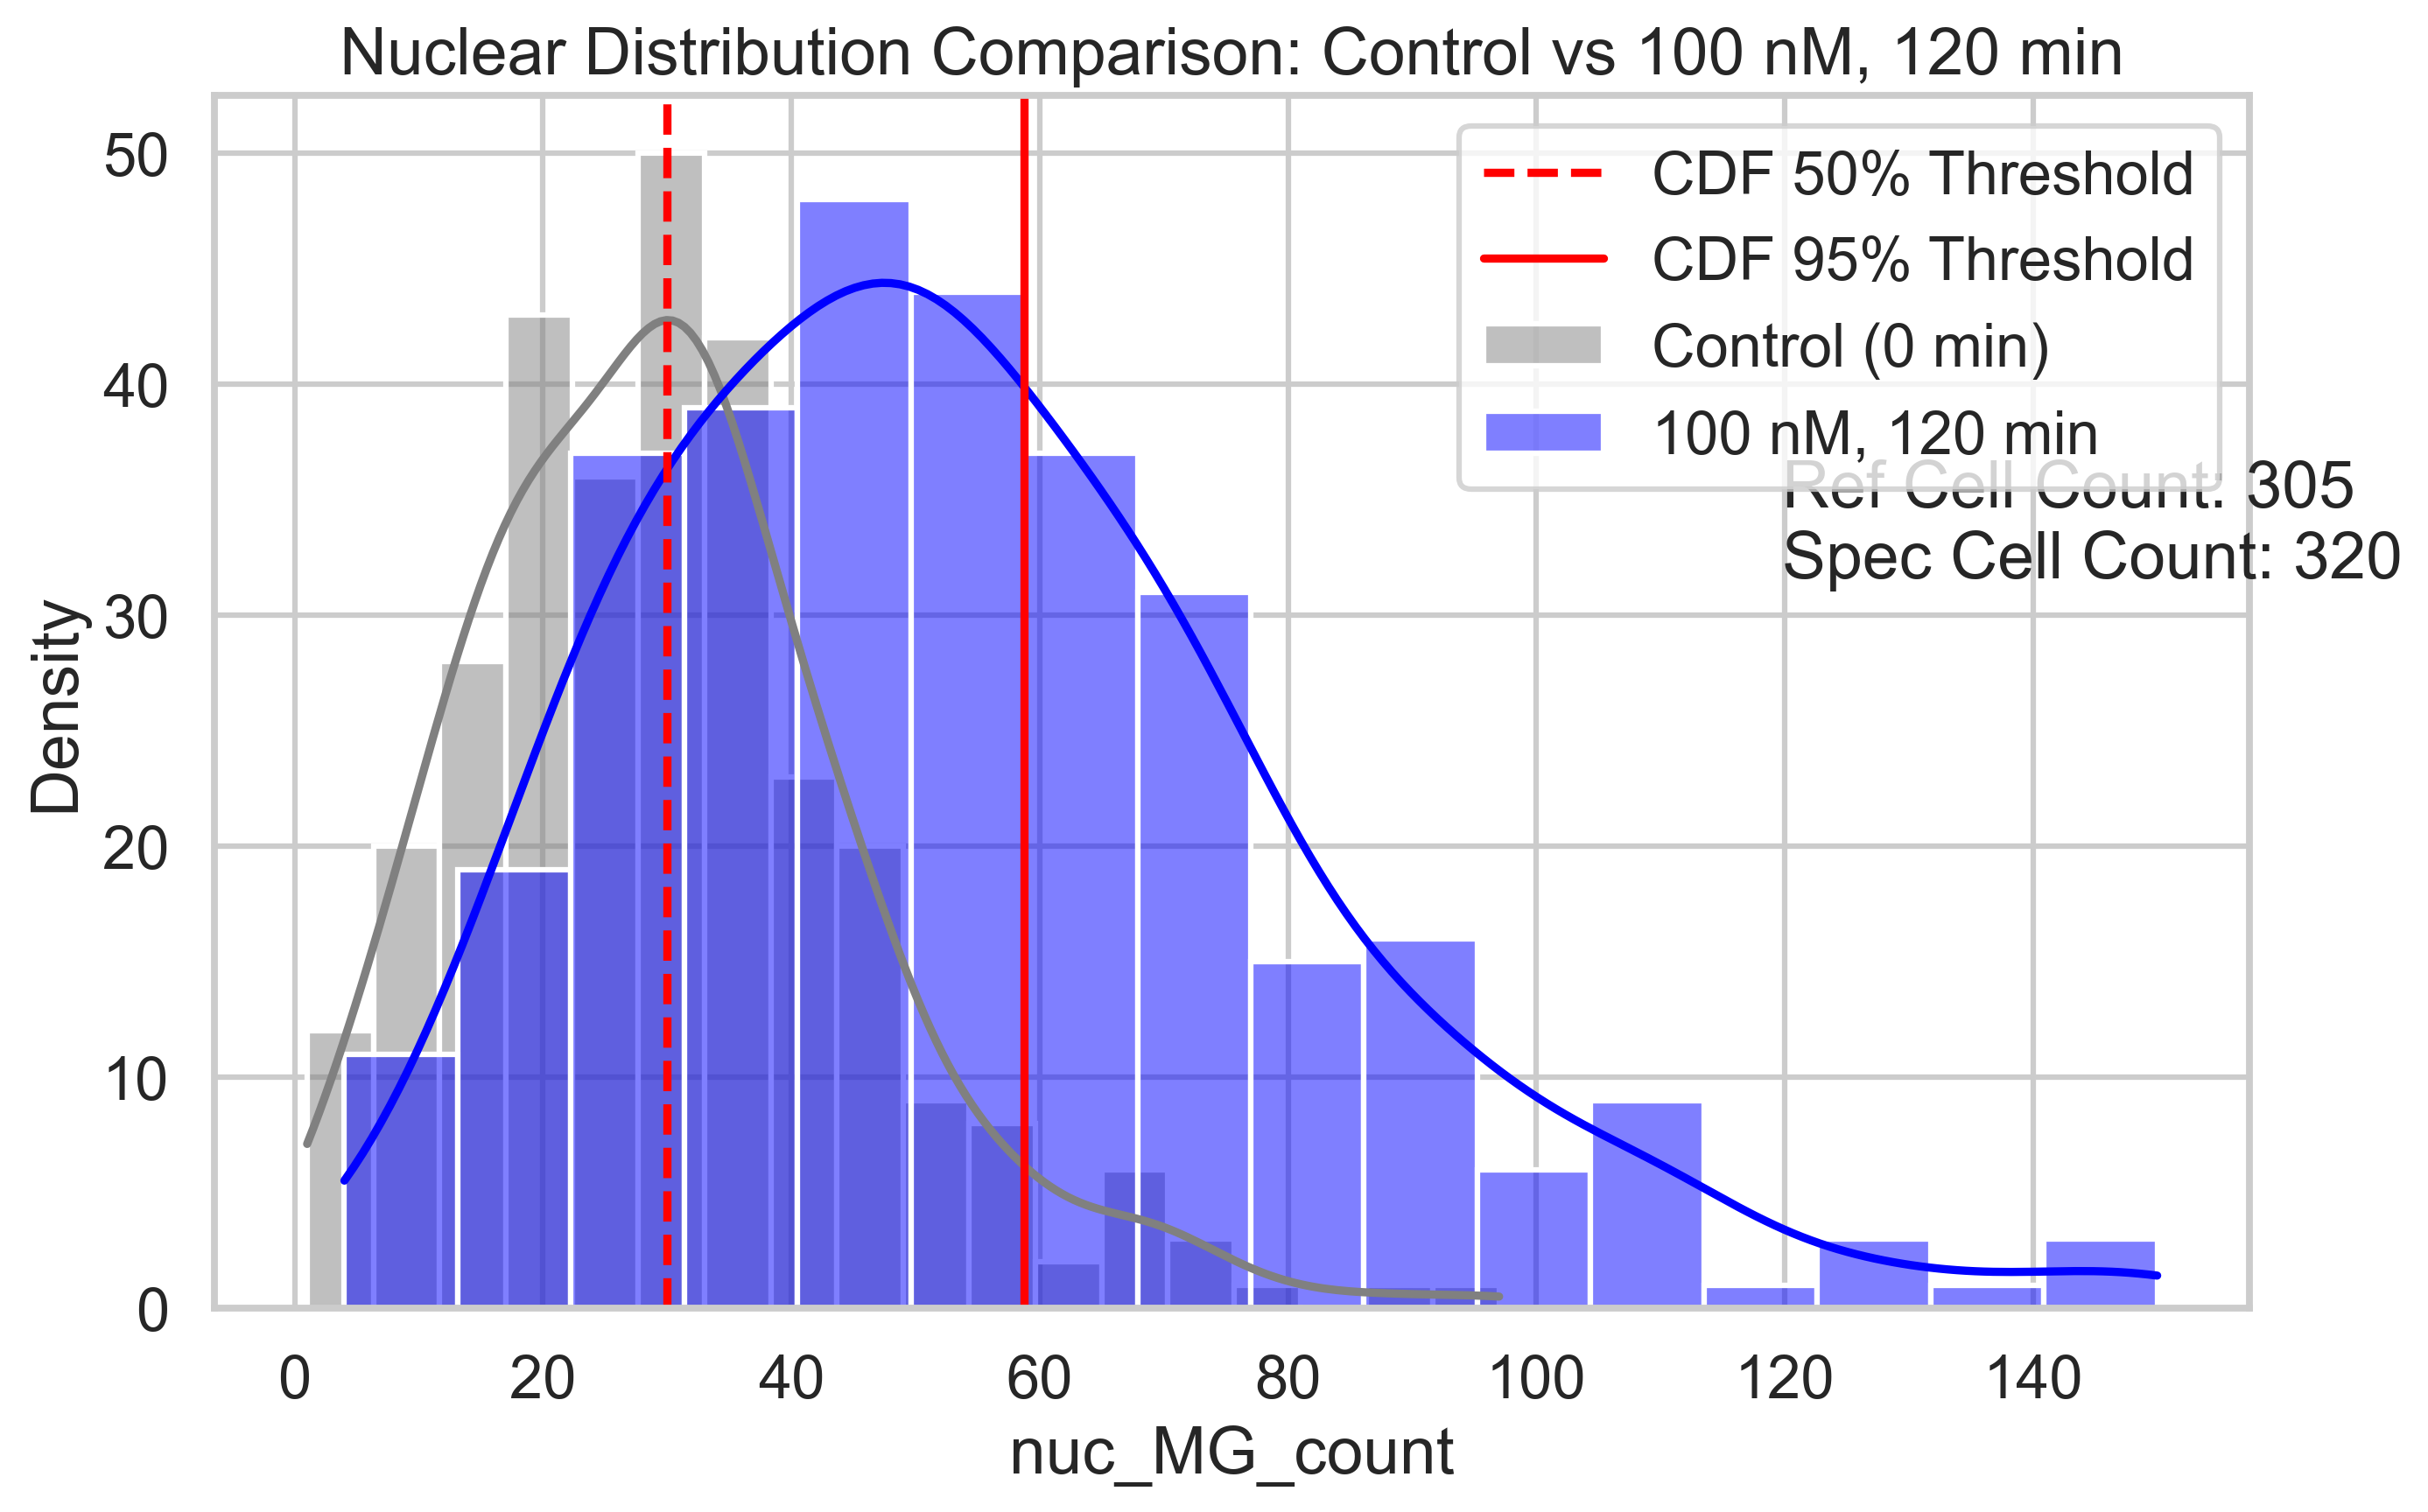

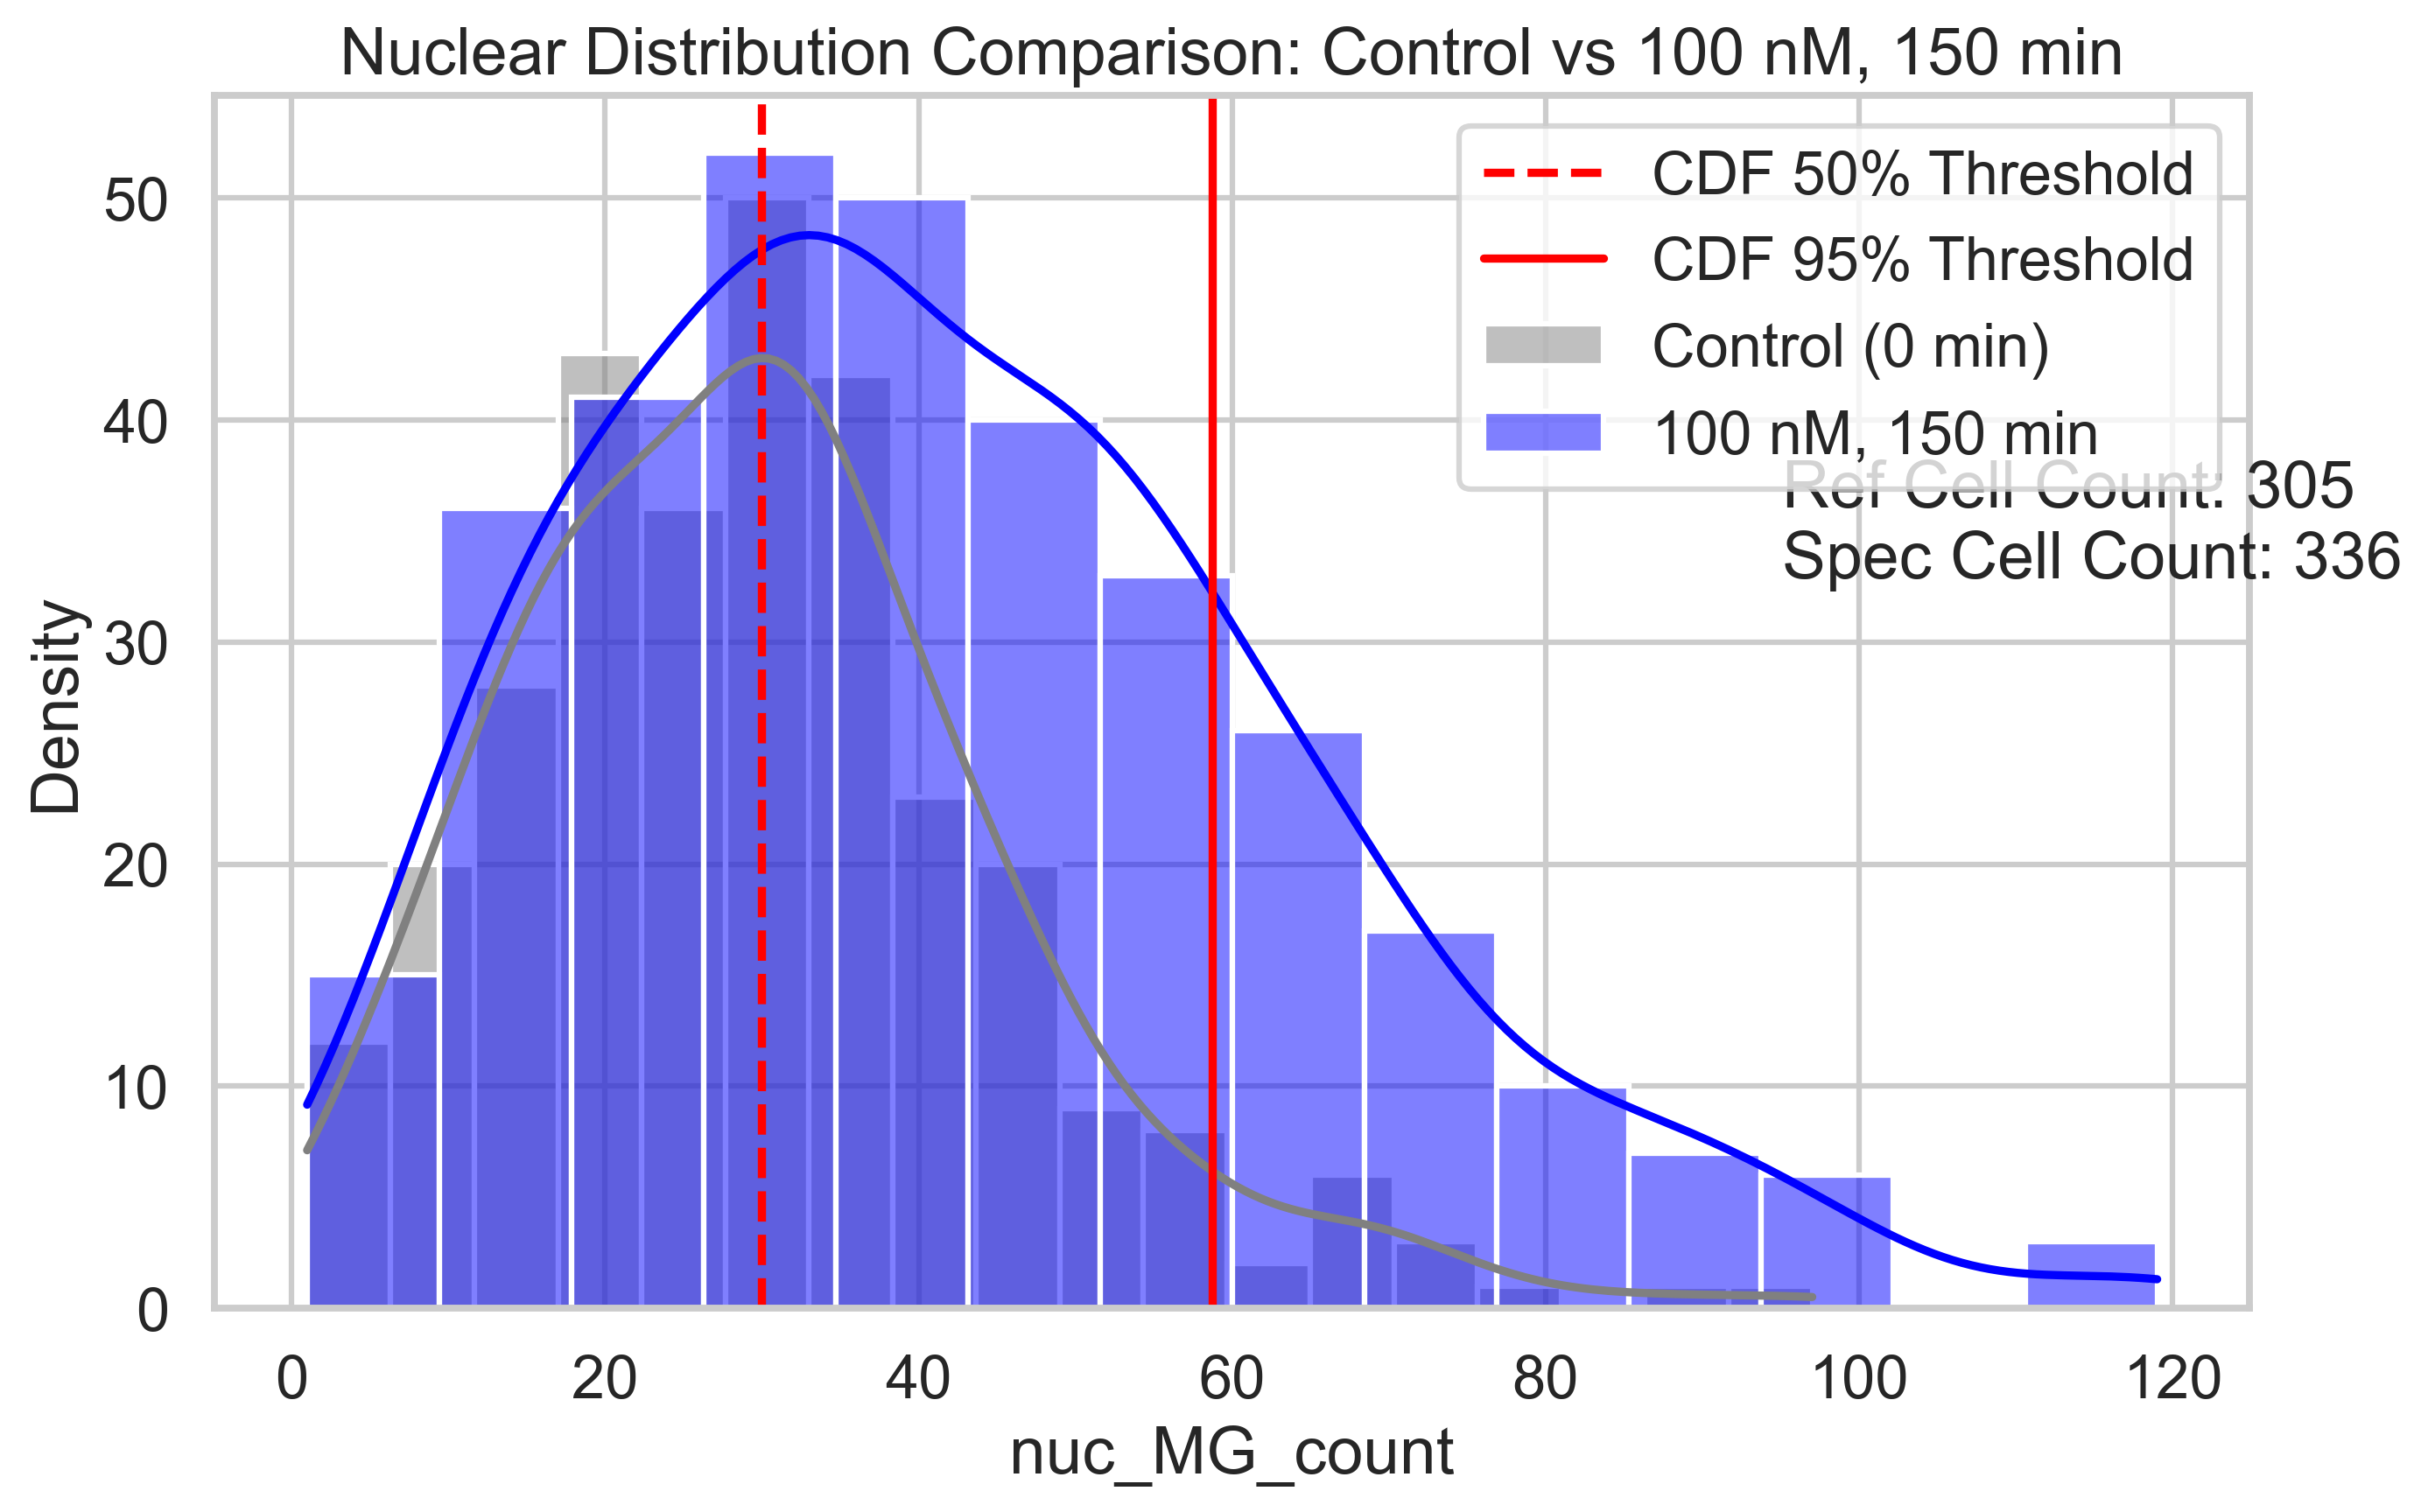

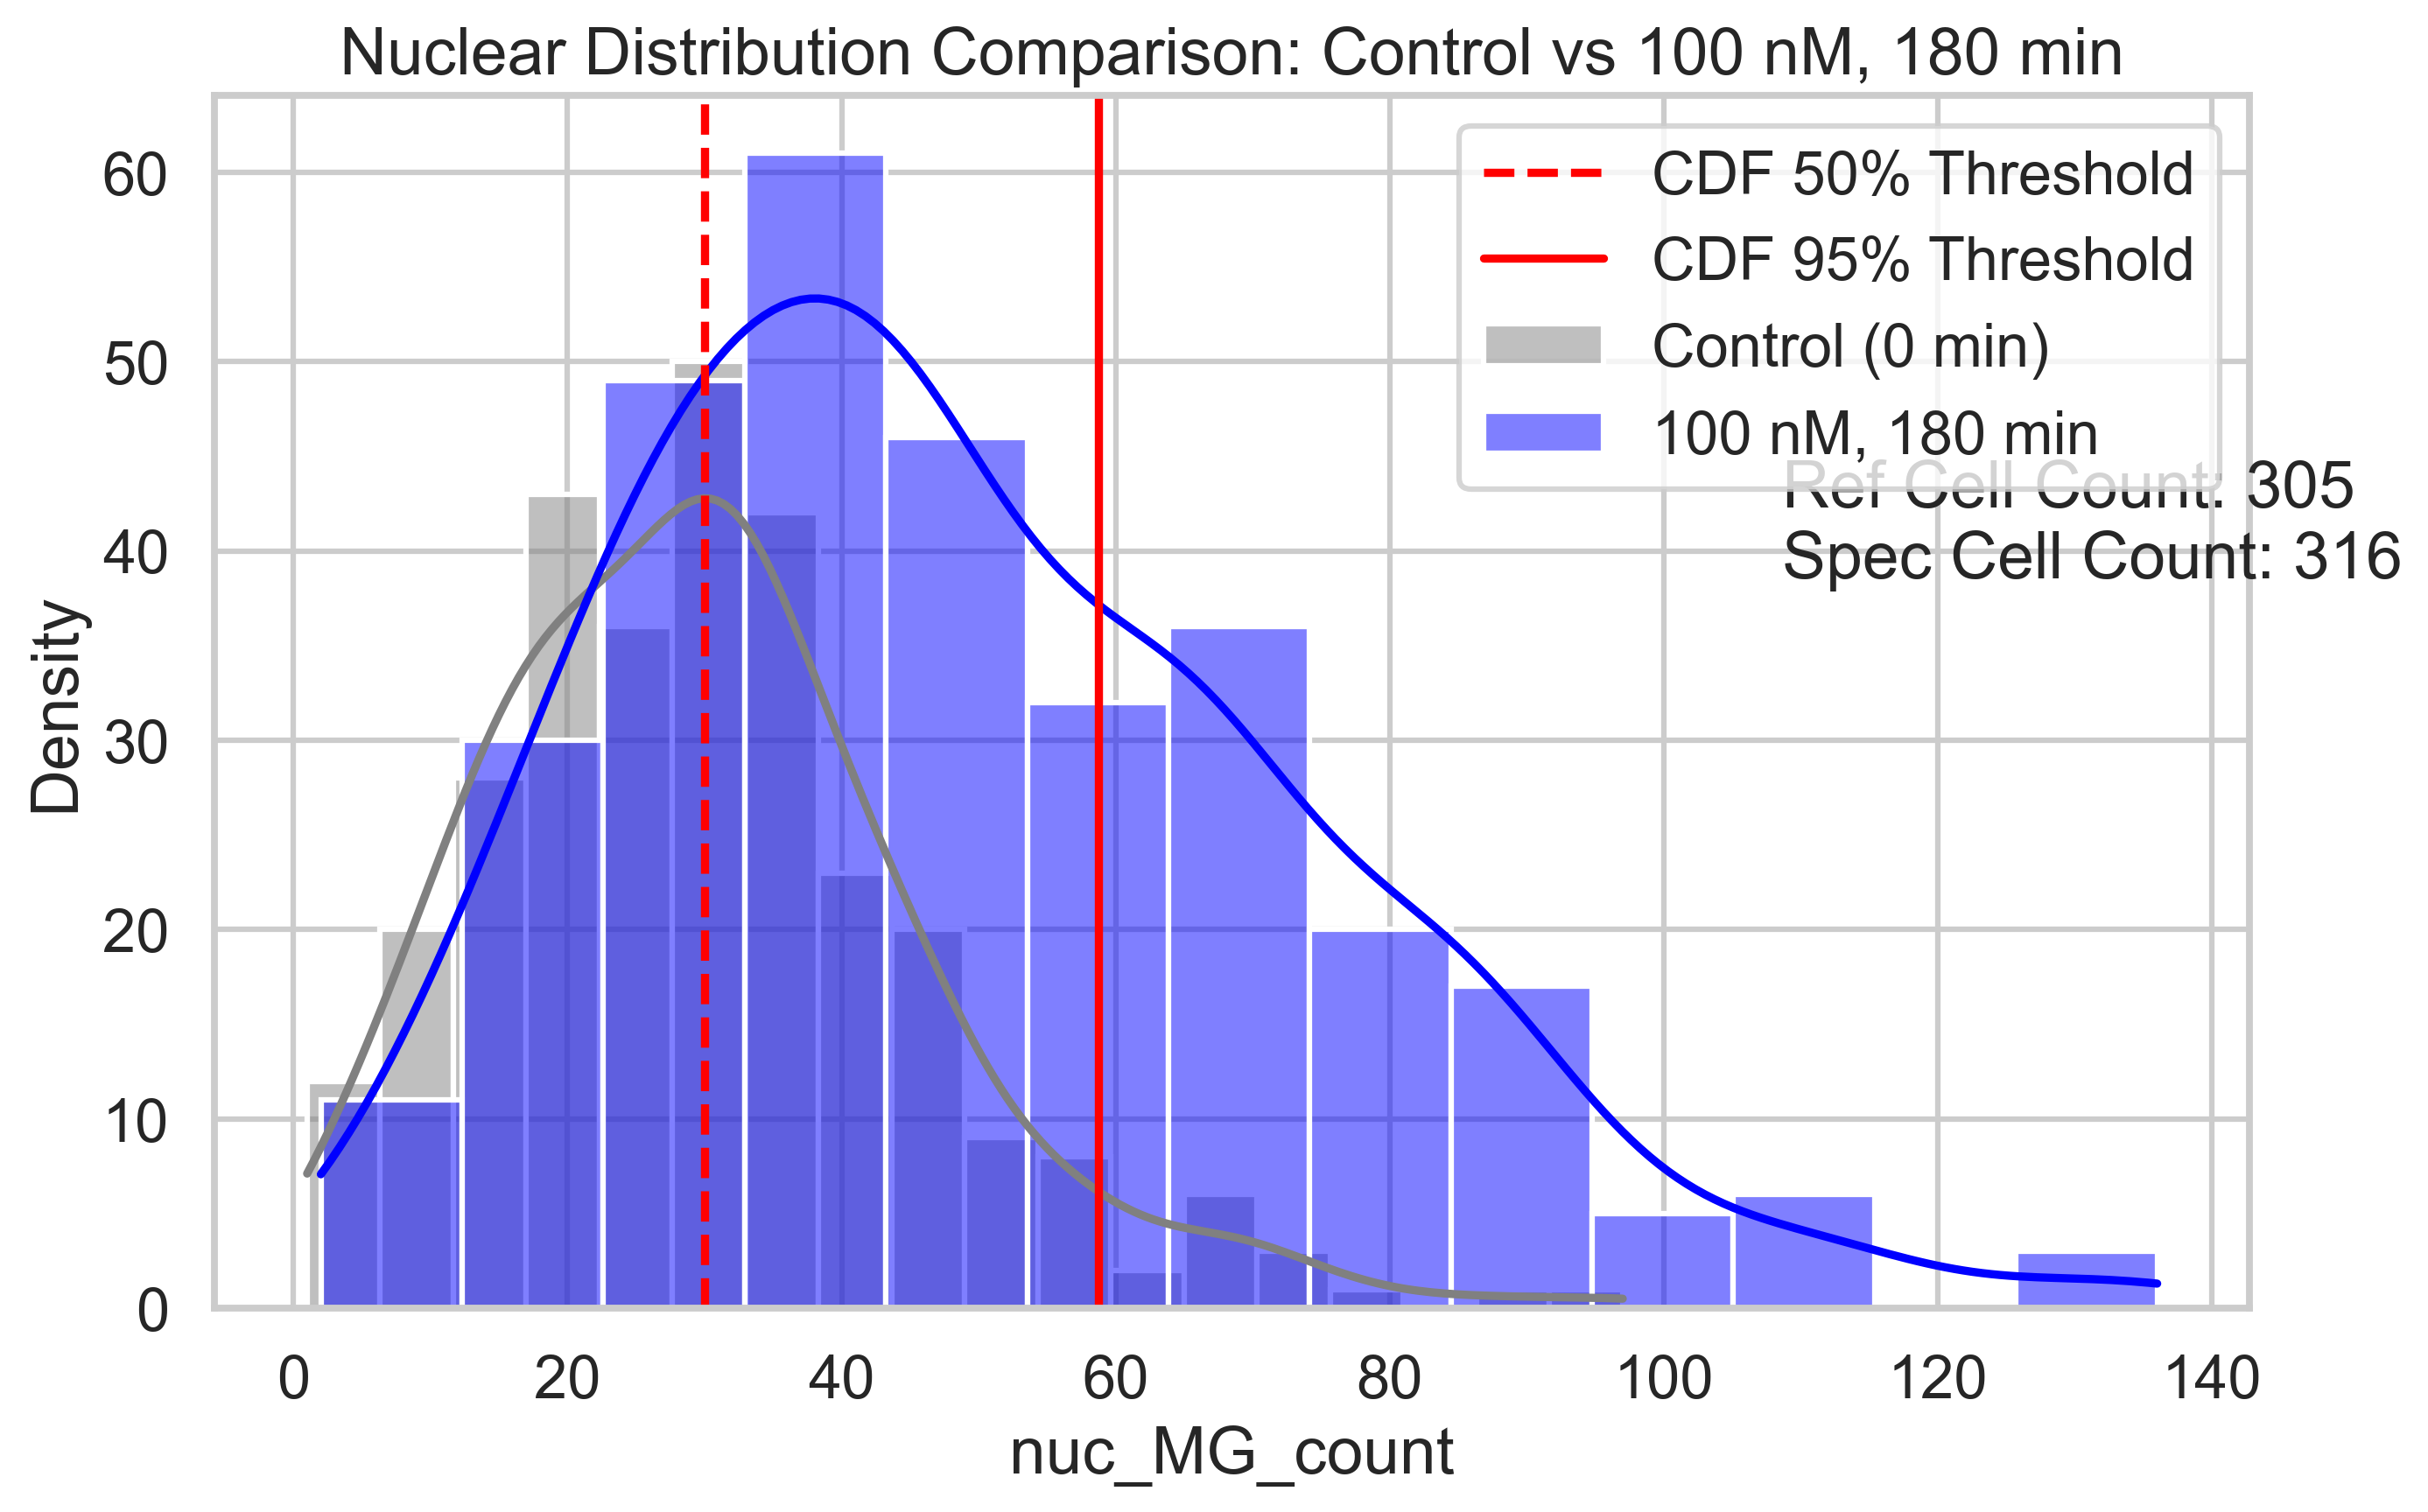

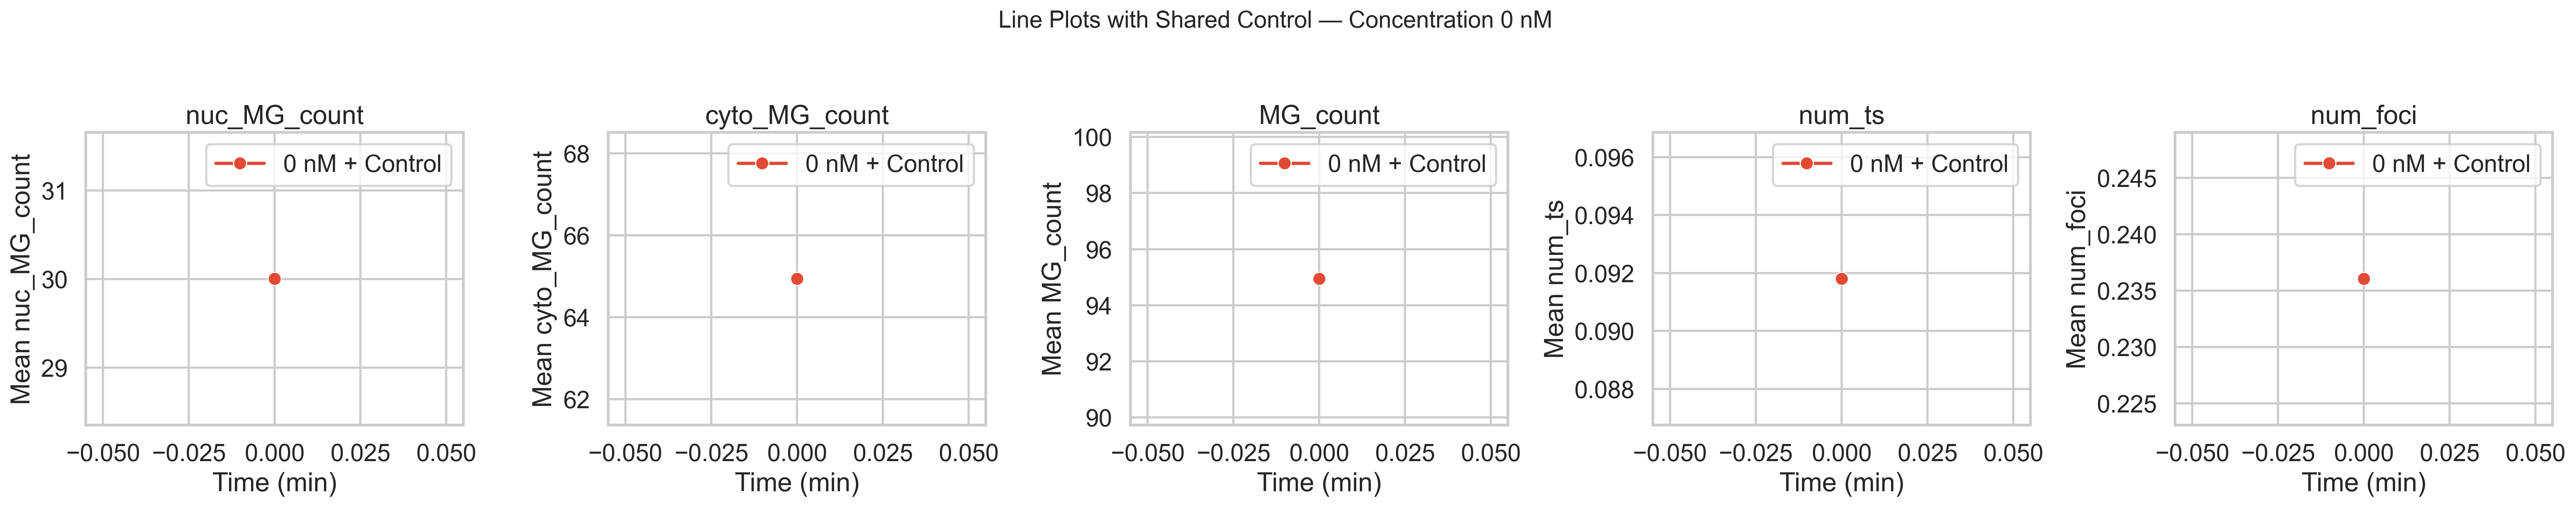

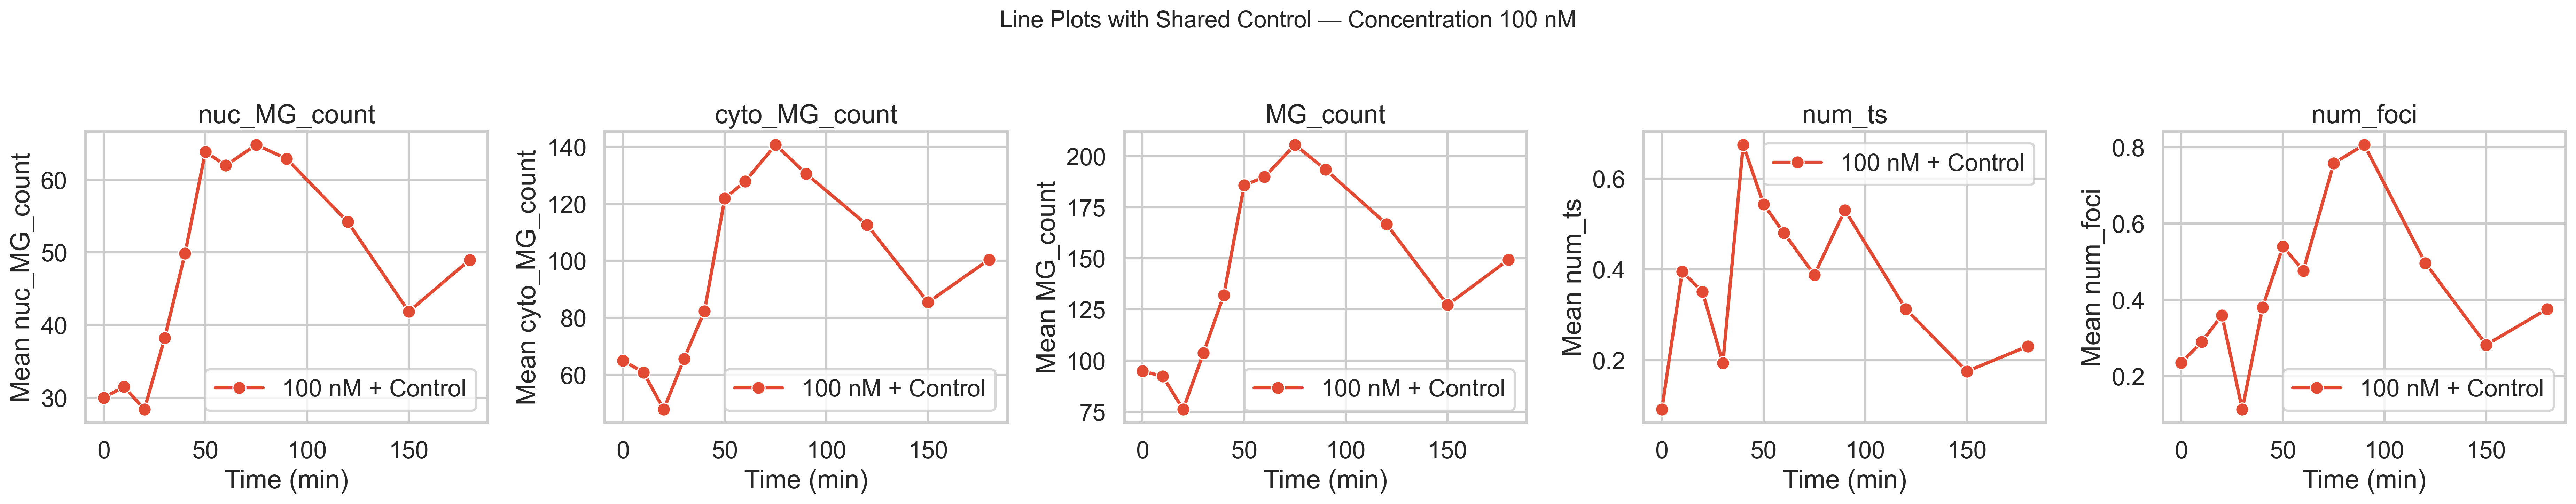

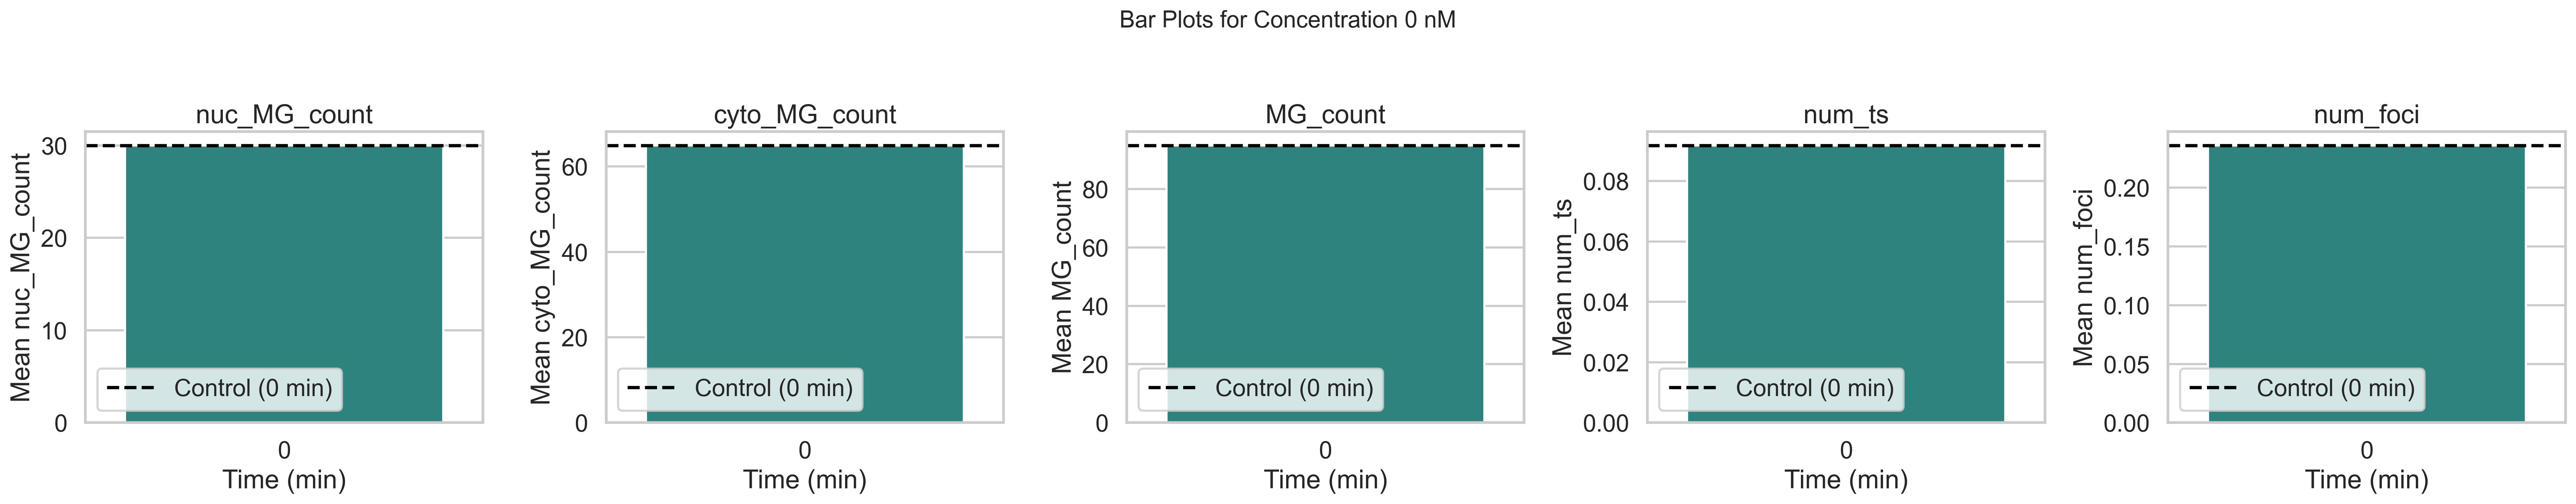

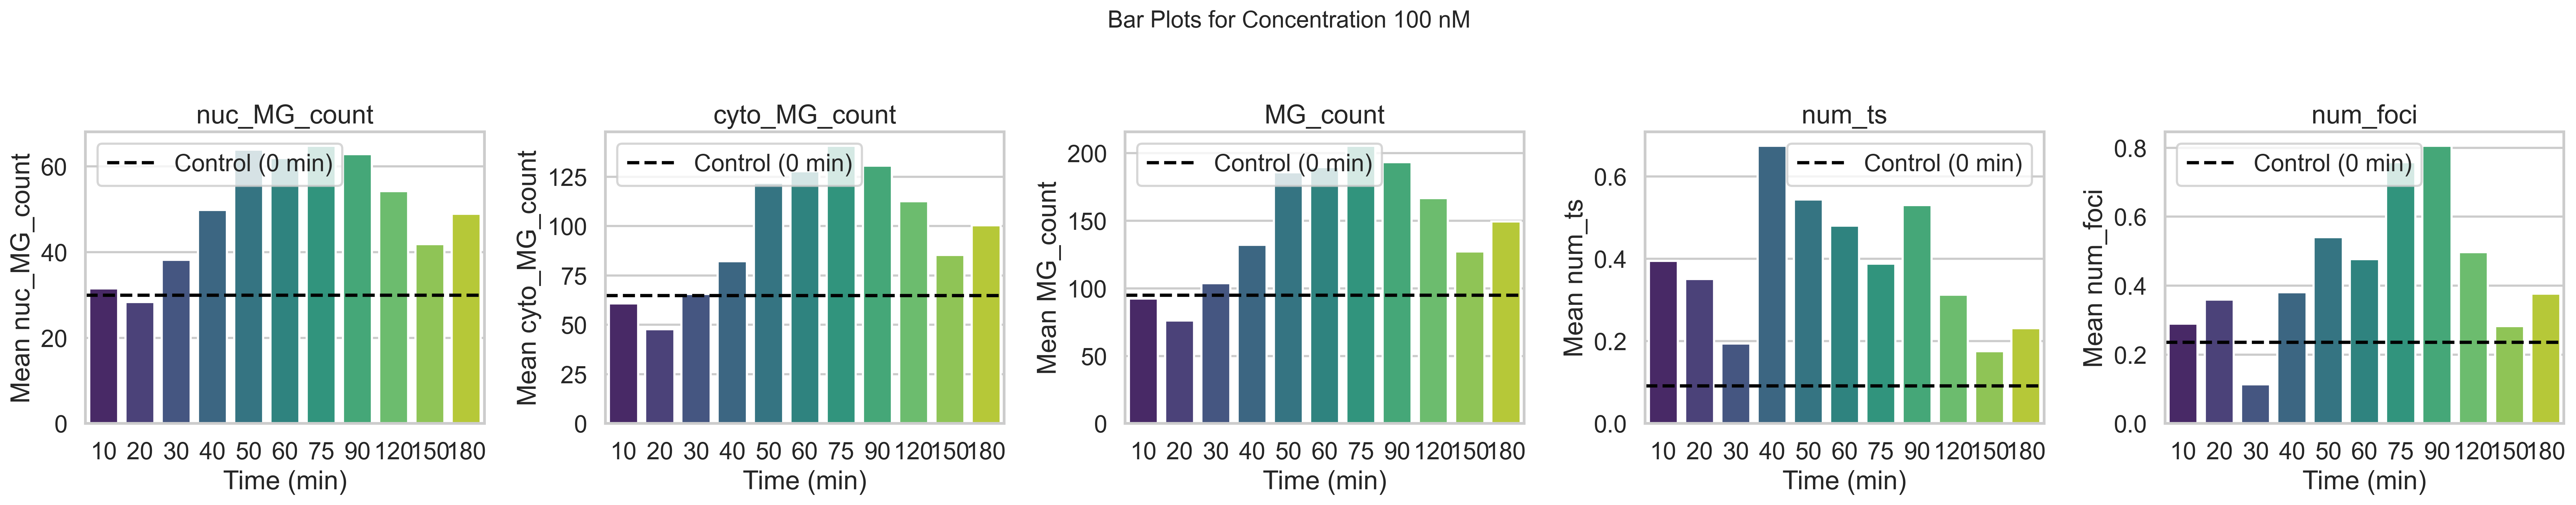

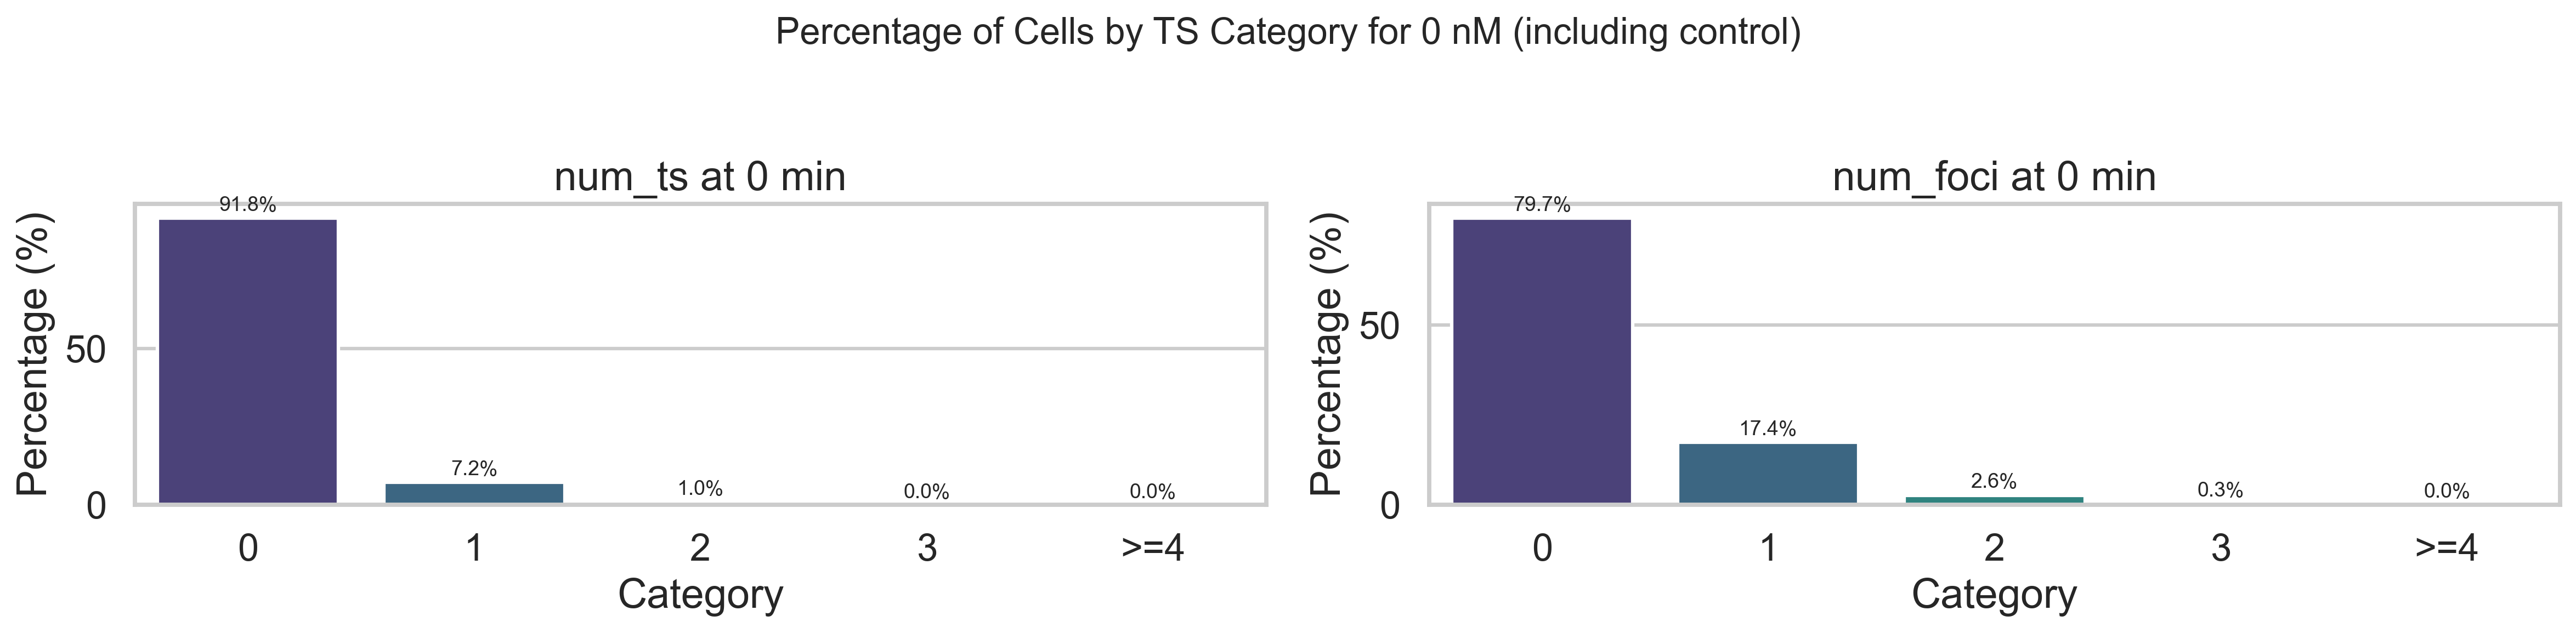

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# ============================================================================
# Settings and Data
# ============================================================================
metrics = ['nuc_MG_count', 'cyto_MG_count', 'MG_count', 'num_ts', 'num_foci']

# Sorted unique values for concentrations and time
concentrations = sorted(filtered_cell_level_results['dex_conc'].unique())
timepoints = sorted(filtered_cell_level_results['time'].unique())

# Set common aesthetics
sns.set_context('talk')
sns.set_style('whitegrid')

# Make a copy of the main dataframe
df = filtered_cell_level_results.copy()

# ============================================================================
# Get the control (baseline) data: all rows with time == 0.
# ============================================================================
reference_data = df[df['time'] == 0]
print("Reference (control) data sample:")
print(reference_data.head())

# For the histograms below, we also calculate CDF thresholds based on one metric.
# (In this example, we use 'nuc_MG_count'; update as needed for other metrics.)
cdf_values = np.sort(reference_data['nuc_MG_count'])
cdf = np.arange(1, len(cdf_values) + 1) / len(cdf_values)
cdf_50_threshold = np.interp(0.50, cdf, cdf_values)
cdf_95_threshold = np.interp(0.95, cdf, cdf_values)

# Define the concentrations and desired timepoints for the histograms (e.g., concentration 100 only)
concentrations_to_plot = [100]  # modify as needed
desired_timepoints = [10, 20, 30, 40, 50, 60, 75, 90, 120, 150, 180]


# ============================================================================
# 1. HISTOGRAMS
# For each desired timepoint and concentration, compare the histogram for the 
# experimental condition (given dex_conc and time) with the control (time==0) data.
# ============================================================================
for time in desired_timepoints:
    for dex_conc in concentrations_to_plot:
        plt.figure(figsize=(10, 6))
        specific_data = df[(df['dex_conc'] == dex_conc) & (df['time'] == time)]
        
        sns.histplot(reference_data['nuc_MG_count'], color='grey', label='Control (0 min)', kde=True)
        sns.histplot(specific_data['nuc_MG_count'], color='blue', label=f'{dex_conc} nM, {time} min', kde=True)
        
        plt.axvline(cdf_50_threshold, color='red', linestyle='--', label='CDF 50% Threshold')
        plt.axvline(cdf_95_threshold, color='red', linestyle='-',  label='CDF 95% Threshold')
        
        plt.annotate(f'Ref Cell Count: {len(reference_data)}\nSpec Cell Count: {len(specific_data)}',
                     xy=(0.77, 0.70), xycoords='axes fraction', verticalalignment='top')
        plt.title(f'Nuclear Distribution Comparison: Control vs {dex_conc} nM, {time} min')
        plt.xlabel('nuc_MG_count')
        plt.ylabel('Density')
        plt.legend()
        plt.show()


# ============================================================================
# 2. LINE PLOTS (with control overlay)
# For each concentration, plot the mean metric value over time
# and overlay a horizontal dashed line indicating the control (0 min) mean.
# ============================================================================
for conc in concentrations:
    fig, axes = plt.subplots(1, len(metrics), figsize=(5 * len(metrics), 5))
    fig.suptitle(f'Line Plots with Shared Control — Concentration {conc} nM', fontsize=16)

    # Experimental data for this concentration
    data_conc = df[df['dex_conc'] == conc]

    # Control data (baseline): dex_conc == 0 and time == 0
    control_data = df[(df['dex_conc'] == 0) & (df['time'] == 0)]

    for i, metric in enumerate(metrics):
        ax = axes[i]

        # Experimental mean metric over time
        grouped_exp = data_conc.groupby('time')[metric].mean().reset_index()

        # Add baseline mean as the 0 min point
        if not control_data.empty:
            control_mean = control_data[metric].mean()
            # Create a new row at time=0
            control_point = pd.DataFrame({'time': [0], metric: [control_mean]})
            # Concatenate with experimental data
            combined = pd.concat([control_point, grouped_exp], ignore_index=True)
        else:
            combined = grouped_exp.copy()

        sns.lineplot(data=combined, x='time', y=metric, marker='o', ax=ax, label=f'{conc} nM + Control')

        ax.set_title(metric)
        ax.set_xlabel('Time (min)')
        ax.set_ylabel(f'Mean {metric}')
        ax.legend()

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


# ============================================================================
# 3. BAR PLOTS (with control overlay)
# For each concentration, plot a bar chart displaying the mean metric value at each timepoint
# and overlay a horizontal dashed line indicating the control (0 min) mean.
# ============================================================================
for conc in concentrations:
    fig, axes = plt.subplots(1, len(metrics), figsize=(5 * len(metrics), 5))
    fig.suptitle(f'Bar Plots for Concentration {conc} nM', fontsize=16)
    
    # Data for this concentration
    data_conc = df[df['dex_conc'] == conc]
    
    for i, metric in enumerate(metrics):
        ax = axes[i]
        df_grouped = data_conc.groupby('time')[metric].mean().reset_index()
        sns.barplot(data=df_grouped, x='time', y=metric, ax=ax, palette='viridis')
        
        # Compute control mean from reference
        control_mean = reference_data[metric].mean()
        ax.axhline(control_mean, color='black', linestyle='--', label='Control (0 min)')
        
        ax.set_title(metric)
        ax.set_xlabel('Time (min)')
        ax.set_ylabel(f'Mean {metric}')
        ax.legend()
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


# ============================================================================
# 4. CATEGORY-BASED BAR PLOTS FOR 'num_ts' and 'num_foci'
# For each concentration, display for each timepoint the fraction (percentage) of cells 
# falling into the categories "0", "1", "2", "3", or ">=4".
# Now baseline (control) data is included by concatenating the control data.
# ============================================================================
def cat_func(x):
    if x == 1:
        return '1'
    elif x == 2:
        return '2'
    elif x == 3:
        return '3'
    elif x >= 4:
        return '>=4'
    else:
        return '0'

cat_metrics = ['num_ts', 'num_foci']

for conc in concentrations:
    data_conc = df[df['dex_conc'] == conc]
    control_data = df[(df['time'] == 0) & (df['dex_conc'] == 0)]
    data_for_plot = pd.concat([control_data, data_conc], ignore_index=True)
    time_points = sorted(data_for_plot['time'].unique())

    fig, axes = plt.subplots(len(time_points), len(cat_metrics), 
                             figsize=(8 * len(cat_metrics), 4 * len(time_points)))

    # ---- MAKE AXES ALWAYS 2D ----
    if len(time_points) == 1 and len(cat_metrics) == 1:
        axes = np.array([[axes]])
    elif len(time_points) == 1:
        axes = np.expand_dims(axes, axis=0)
    elif len(cat_metrics) == 1:
        axes = np.expand_dims(axes, axis=1)
    # -----------------------------

    fig.suptitle(f'Percentage of Cells by TS Category for {conc} nM (including control)', fontsize=16)

    for row, t in enumerate(time_points):
        for col, metric in enumerate(cat_metrics):
            ax = axes[row][col]
            subset = data_for_plot[data_for_plot['time'] == t].copy()
            subset['category'] = subset[metric].apply(cat_func)

            counts = subset['category'].value_counts(normalize=True).sort_index() * 100
            categories = ['0', '1', '2', '3', '>=4']
            counts = counts.reindex(categories, fill_value=0)

            sns.barplot(x=counts.index, y=counts.values, ax=ax, palette='viridis')
            ax.set_title(f'{metric} at {t} min')
            ax.set_xlabel('Category')
            ax.set_ylabel('Percentage (%)')

            for i, v in enumerate(counts.values):
                ax.text(i, v + 1, f"{v:.1f}%", ha='center', va='bottom', fontsize=9)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

In [ ]:
# filtered_cell_level_results.head()
# filtered_clusters.keys()
# filtered_cellprops.keys()
filtered_spots.keys()

In [ ]:
# Example usage:
am = DUSP1AnalysisManager(location=loc, log_location=log_location, mac=True)
am.select_analysis('DUSP1_D_Final')

display_manager = DUSP1DisplayManager(am, 
                                      cell_level_results=filtered_cell_level_results,
                                      spots=filtered_spots,
                                      clusters=filtered_clusters,
                                      cellprops=filtered_cellprops,
                                      method='MG')
# Run the main display function.
display_manager.main_display()